In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
# import LogNorm
from matplotlib.colors import LogNorm


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [3]:
from itertools import product
from training_info import TrainingInfo
from plots import calibration_plot, plot_rewighted_samples_by_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ancillary_features import get_m4j
from pl_callbacks import CalibrationPlotCallback, ReweightedPlotCallback

# use tex
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.labelsize"] = 20
plt.rcParams["lines.markersize"] = 3

In [4]:
import time
import pytorch_lightning as pl
from events_data import events_from_scdinfo
from dataset import MotherSamples
from training_info import TrainingInfo
from attention_classifier import AttentionClassifier

n_3b = 100_0000
device = torch.device("cuda")
# experiment_name = "smeared_fvt_training"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
signal_ratio = 0.0

# seeds = np.arange(20)
hparam_filter = {
    # "experiment_name": lambda x: x in [experiment_name],
    "dataset": lambda x: x["n_3b"] == n_3b,
    # "model": "AttentionClassifier", 
    "aux_info_step": 1
}
hashes, hparams = TrainingInfo.find(hparam_filter, return_hparams=True)

print(np.unique([hparam["dataset"]["seed"] for hparam in hparams]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]


# Updating unsaved hparams

In [5]:
# import time
# import pytorch_lightning as pl
# from events_data import events_from_scdinfo
# from dataset import MotherSamples
# from training_info import TrainingInfo
# from attention_classifier import AttentionClassifier

# n_3b = 100_0000
# device = torch.device("cuda")
# experiment_name = "smeared_fvt_training"
# signal_filename = "HH4b_picoAOD.h5"
# ratio_4b = 0.5
# signal_ratio = 0.0

# seeds = np.arange(20)
# # seeds = [0]
# hparam_filter = {
#     "experiment_name": lambda x: x in [experiment_name],
#     "dataset": lambda x: all([x["seed"] in seeds, 
#                               x["n_3b"] == n_3b]),
#     "model": "AttentionClassifier"
# }
# hashes = TrainingInfo.find(hparam_filter)

# for tinfo_hash in hashes:
#     smeared_tinfo = TrainingInfo.load(tinfo_hash)
#     seed = smeared_tinfo.hparams["dataset"]["seed"]
    
#     for mode in ["best", "last"]:
#         smeared_loaded = torch.load(f"./data/checkpoints/{smeared_tinfo.hash}_{mode}.ckpt")
#         if "hyper_parameters" in smeared_loaded:
#             print("hyper_parameters already exists")
#             continue
#         else:
#             smeared_loaded["hyper_parameters"] = {"dim_q": 6, "num_classes": 2, "run_name": smeared_tinfo.hash, "depth": 8}
#             torch.save(smeared_loaded, f"./data/checkpoints/{smeared_tinfo.hash}_{mode}.ckpt")
    
#     smeared_tinfo.update_aux_info(
#         description=f"Step 2: smeared_FvT_based_on_{smeared_tinfo.hparams['encoder_hash']}",
#         step=2
#     )
#     smeared_tinfo.save()
    


In [6]:
# import time
# import pytorch_lightning as pl
# from events_data import events_from_scdinfo
# from dataset import MotherSamples
# from training_info import TrainingInfo
# from attention_classifier import AttentionClassifier
# from plots import plot_sr_stats
# import tqdm

# n_3b = 100_0000
# device = torch.device("cuda")
# experiment_name = "smeared_fvt_training"
# signal_filename = "HH4b_picoAOD.h5"
# ratio_4b = 0.5

# for signal_ratio in [0.01, 0.02]:
#     seeds = np.arange(10)
#     hparam_filter = {
#         "experiment_name": lambda x: x in [experiment_name],
#         "dataset": lambda x: all([x["seed"] in seeds, 
#                                 x["n_3b"] == n_3b, 
#                                 x["signal_ratio"] == signal_ratio]),
#         "model": "AttentionClassifier"
#     }
#     hashes = TrainingInfo.find(hparam_filter)
    
#     fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
#     fig.suptitle(f"signal_ratio={signal_ratio}, n_3b={n_3b}")

#     for ax_cnt, tinfo_hash in tqdm.tqdm(enumerate(hashes)):
#         smeared_tinfo = TrainingInfo.load(tinfo_hash)
#         seed = smeared_tinfo.hparams["dataset"]["seed"]
#         smeared_fvt = smeared_tinfo.load_trained_model("best")
#         smeared_fvt.eval()
#         smeared_fvt.to(device)
        
#         base_tinfo = TrainingInfo.load(smeared_tinfo.hparams["encoder_hash"])
#         loaded = torch.load(f"./data/checkpoints/{base_tinfo.hash}_best.ckpt")
#         base_fvt = base_tinfo.load_trained_model("best")
#         base_fvt.eval()
#         base_fvt.to(device)
        
#         msamples = MotherSamples.load(smeared_tinfo.ms_hash)
#         tst_scdinfo = msamples.scdinfo[~smeared_tinfo.ms_idx]
#         events_tst = events_from_scdinfo(tst_scdinfo, features, signal_filename)
#         events_tst.shuffle(seed=seed)
        
#         probs_4b_base = base_fvt.predict(events_tst.X_torch)[:, 1].detach().cpu().numpy()
#         q_repr_tst = base_fvt.representations(events_tst.X_torch)[0]
#         probs_4b_smeared = smeared_fvt.predict(q_repr_tst)[:, 1].detach().cpu().numpy()
#         gamma_base = probs_4b_base / (1 - probs_4b_base)
#         gamma_smeared = probs_4b_smeared / (1 - probs_4b_smeared)
        
#         ax_idx = ax_cnt // 5
#         ax_idy = ax_cnt % 5
#         fig.suptitle(f"seed={seed}, n_3b={n_3b}, signal_ratio={signal_ratio}")
#         plot_sr_stats(events_tst, gamma_base, ax=ax[ax_idx, ax_idy], label="base")
#         plot_sr_stats(events_tst, gamma_smeared, ax=ax[ax_idx, ax_idy], label="smeared")
#         plot_sr_stats(events_tst, gamma_base / gamma_smeared, ax=ax[ax_idx, ax_idy], label="base / smeared")
#         ax[ax_idx, ax_idy].legend()
#     plt.show()


In [7]:
def get_SR_CR_cut(SR_stats: np.ndarray, events_tst: EventsData, SRCR_hparams: dict):
    assert len(SR_stats) == len(events_tst)
    assert "4b_in_SR" in SRCR_hparams and "4b_in_CR" in SRCR_hparams
    
    W_4B_CUT_MIN = 0.001
    W_4B_CUT_MAX = 0.999
    
    
    SR_stats_argsort = np.argsort(SR_stats)[::-1]
    SR_stats_sorted = SR_stats[SR_stats_argsort]
    weights = events_tst.weights[SR_stats_argsort]
    is_4b = events_tst.is_4b[SR_stats_argsort]
    cumul_4b_ratio = np.cumsum(weights * is_4b) / np.sum(weights * is_4b)

    w_4b_SR_ratio = np.clip(SRCR_hparams["4b_in_SR"], W_4B_CUT_MIN, W_4B_CUT_MAX)
    w_4b_CR_ratio = np.clip(
        SRCR_hparams["4b_in_CR"] + SRCR_hparams["4b_in_SR"], W_4B_CUT_MIN, W_4B_CUT_MAX
    )

    SR_cut, CR_cut = None, None
    for i in range(1, len(cumul_4b_ratio)):
        if cumul_4b_ratio[i] > w_4b_SR_ratio and SR_cut is None:
            SR_cut = SR_stats_sorted[i - 1]
        if cumul_4b_ratio[i] > w_4b_CR_ratio and CR_cut is None:
            CR_cut = SR_stats_sorted[i - 1]
        if SR_cut is not None and CR_cut is not None:
            break

    # If the cut is not found, set the cut to the minimum value
    # Both SR and CR cuts should be different
    if SR_cut is None:
        SR_cut = SR_stats_sorted[-1]
    if CR_cut is None:
        CR_cut = SR_stats_sorted[-1]
    if SR_cut == CR_cut:
        raise ValueError("SR and CR cuts are the same")

    return SR_cut, CR_cut

In [8]:
fvt_config = {
    "model": "FvTClassifier",
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "depth": {
        "encoder": 4,
        "decoder": 1
    },
    "fit_batch_size": 1024,
    "model_seed": 0,
    "train_seed": 0,
    "data_seed": 0,
    "max_epochs": 100,
    "val_ratio": 0.33,
    "early_stop_patience": None,
    "optimizer": {
        "type": "Adam",
        "lr": 0.01
    },
    "lr_scheduler": {
        "type": "ReduceLROnPlateau",
        "factor": 0.5,
        "threshold": 0.0001,
        "patience": 10,
        "cooldown": 1,
        "min_lr": 0.0002
    },
    "dataloader": {
        "batch_size": 1024,
        "batch_size_multiplier": 2,
        "batch_size_milestones": [1, 3, 6, 10, 15]
    }
}

att_config = {
    "model": "AttentionClassifier",
    "dim_q": 6,
    "num_classes": 2,
    "depth": 8,
    "fit_batch_size": 1024,
    "model_seed": 0,
    "train_seed": 0,
    "data_seed": 0,
    "max_epochs": 30,
    "val_ratio": 0.33,
    "early_stop_patience": None,
    "optimizer": {
        "type": "Adam",
        "lr": 0.01
    },
    "lr_scheduler": {
        "type": "ReduceLROnPlateau",
        "factor": 0.25,
        "threshold": 0.0001,
        "patience": 3,
        "cooldown": 1,
        "min_lr": 0.0002
    },
    "dataloader": {
        "batch_size": 1024,
        "batch_size_multiplier": 2,
        "batch_size_milestones": [1, 3, 6, 10, 15]
    }
}


In [9]:
n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "smeared_fvt_training"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
seeds = [0, 3, 6, 9]
signal_ratio = 0.0

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "dataset": lambda x: all([x["seed"] in seeds, 
                            x["n_3b"] == n_3b, 
                            x["signal_ratio"] == signal_ratio]),
    "model": "AttentionClassifier"
}
hashes = TrainingInfo.find(hparam_filter)

SRCR_hparams = {
    "4b_in_SR": 0.05,
    "4b_in_CR": 0.45
}
cal_bins = np.linspace(0, 1, 4)
quantiles = np.linspace(0, 1, 4)

for tinfo_hash in tqdm.tqdm(hashes):
    smeared_tinfo = TrainingInfo.load(tinfo_hash)
    seed = smeared_tinfo.hparams["dataset"]["seed"]
    smeared_fvt = smeared_tinfo.load_trained_model("best")
    smeared_fvt.eval()
    smeared_fvt.to(device)
    
    base_tinfo = TrainingInfo.load(smeared_tinfo.hparams["encoder_hash"])
    loaded = torch.load(f"./data/checkpoints/{base_tinfo.hash}_best.ckpt")
    base_fvt = base_tinfo.load_trained_model("best")
    base_fvt.eval()
    base_fvt.to(device)
    
    msamples = MotherSamples.load(smeared_tinfo.ms_hash)
    tst_scdinfo = msamples.scdinfo[~smeared_tinfo.ms_idx]
    events_tst = events_from_scdinfo(tst_scdinfo, features, signal_filename)
    # Should not be shuffled
    
    probs_4b_base = base_fvt.predict(events_tst.X_torch)[:, 1].detach().cpu().numpy()
    q_repr_tst = base_fvt.representations(events_tst.X_torch)[0]
    probs_4b_smeared = smeared_fvt.predict(q_repr_tst)[:, 1].detach().cpu().numpy()
    gamma_base = probs_4b_base / (1 - probs_4b_base)
    gamma_smeared = probs_4b_smeared / (1 - probs_4b_smeared)
    
    SR_stats = gamma_base / gamma_smeared
    
    SR_cut, CR_cut = get_SR_CR_cut(SR_stats, events_tst, SRCR_hparams)
    
    SR_idx = (SR_stats >= SR_cut)
    CR_idx = (SR_stats >= CR_cut) & (SR_stats < SR_cut)
    
    events_tst_SR = events_tst[SR_idx]
    events_tst_CR = events_tst[CR_idx]
    
    q_repr_tst_SR = base_fvt.representations(events_tst_SR.X_torch)[0]
    q_repr_tst_CR = base_fvt.representations(events_tst_CR.X_torch)[0]

NameError: name 'tqdm' is not defined

  0%|          | 0/3 [00:00<?, ?it/s]

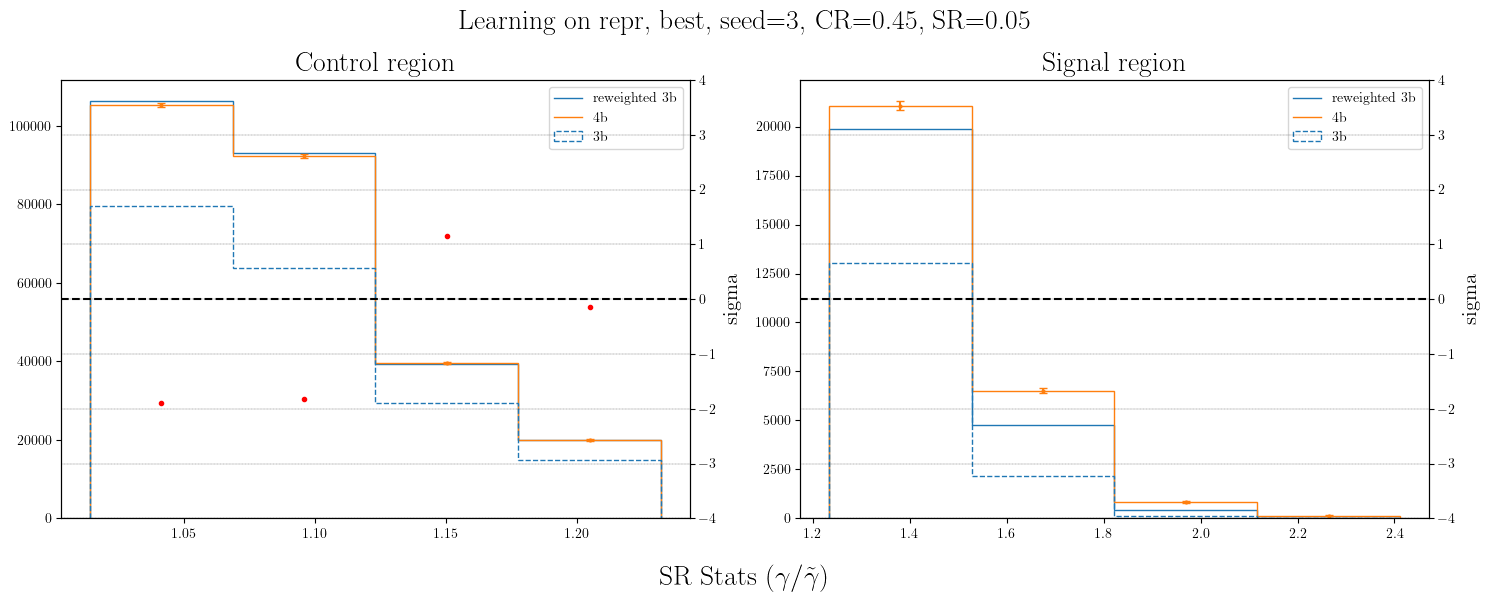

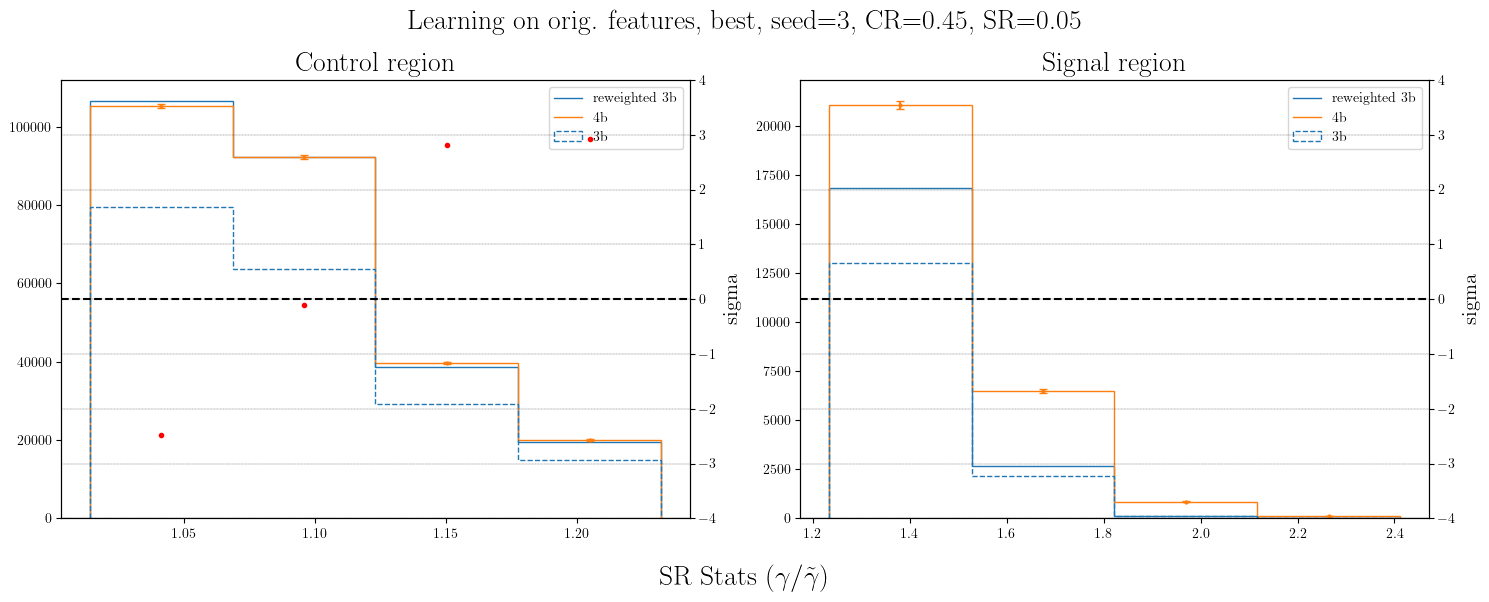

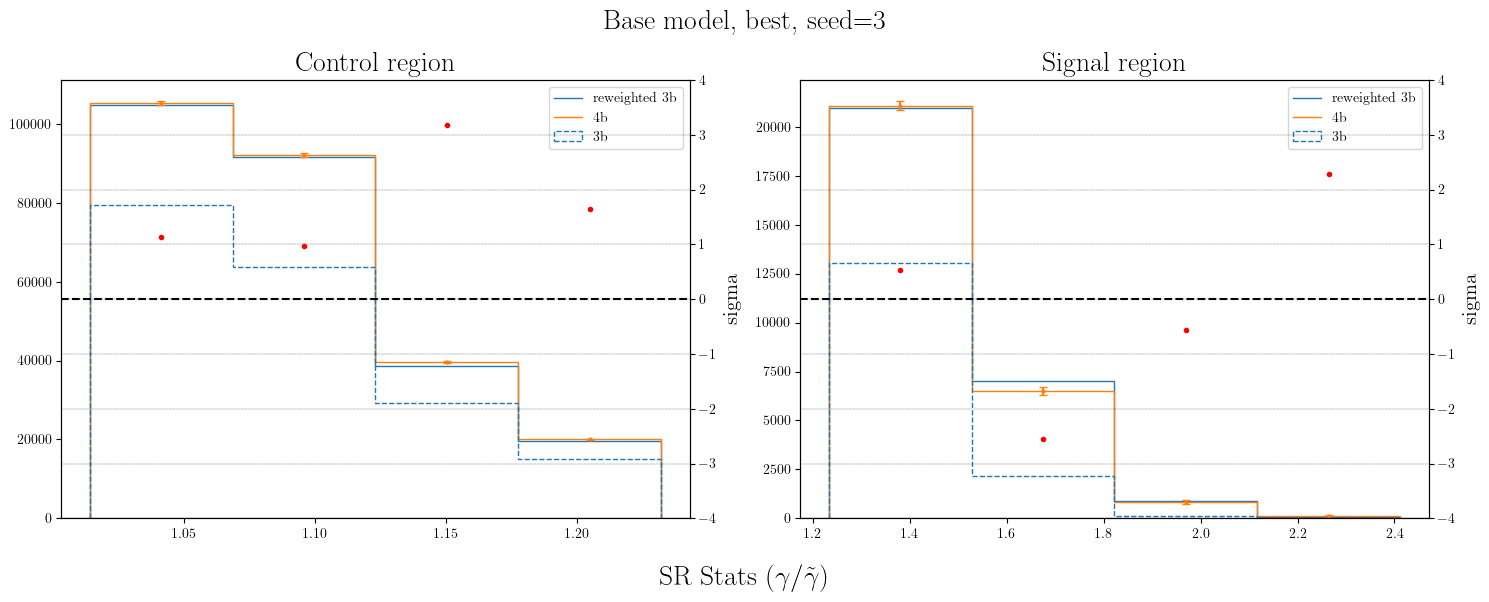

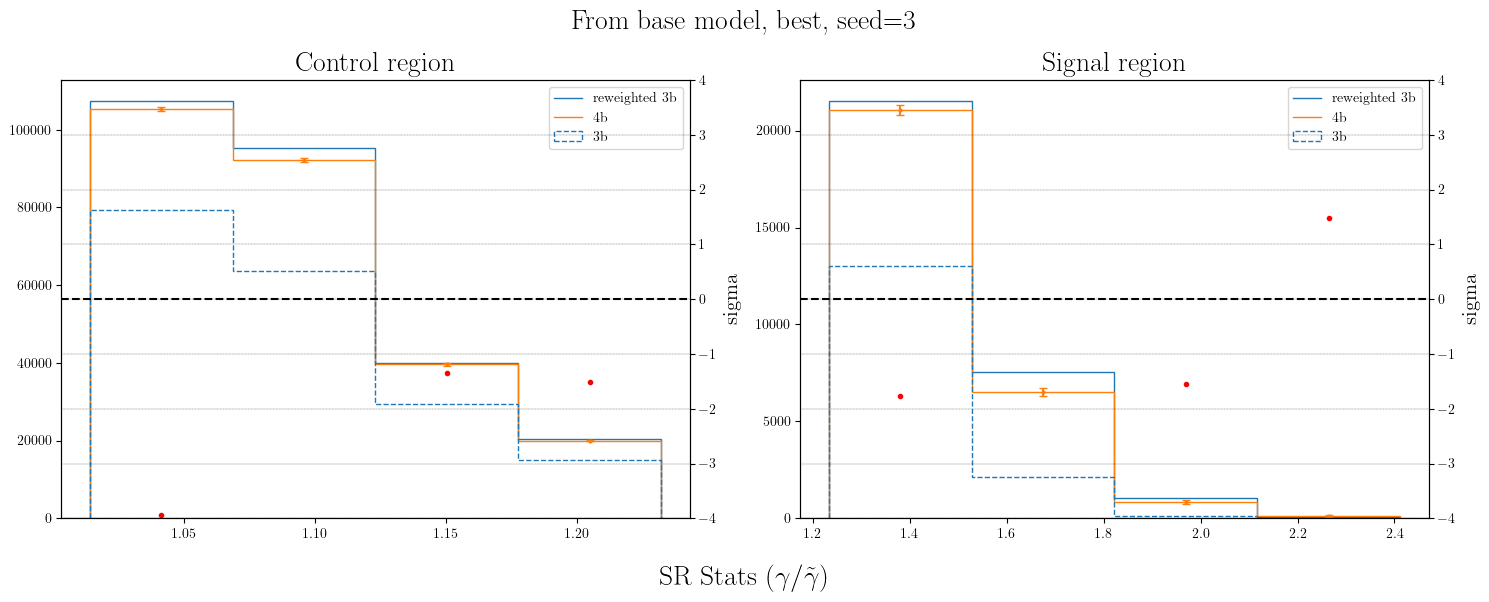

 33%|███▎      | 1/3 [00:24<00:48, 24.04s/it]

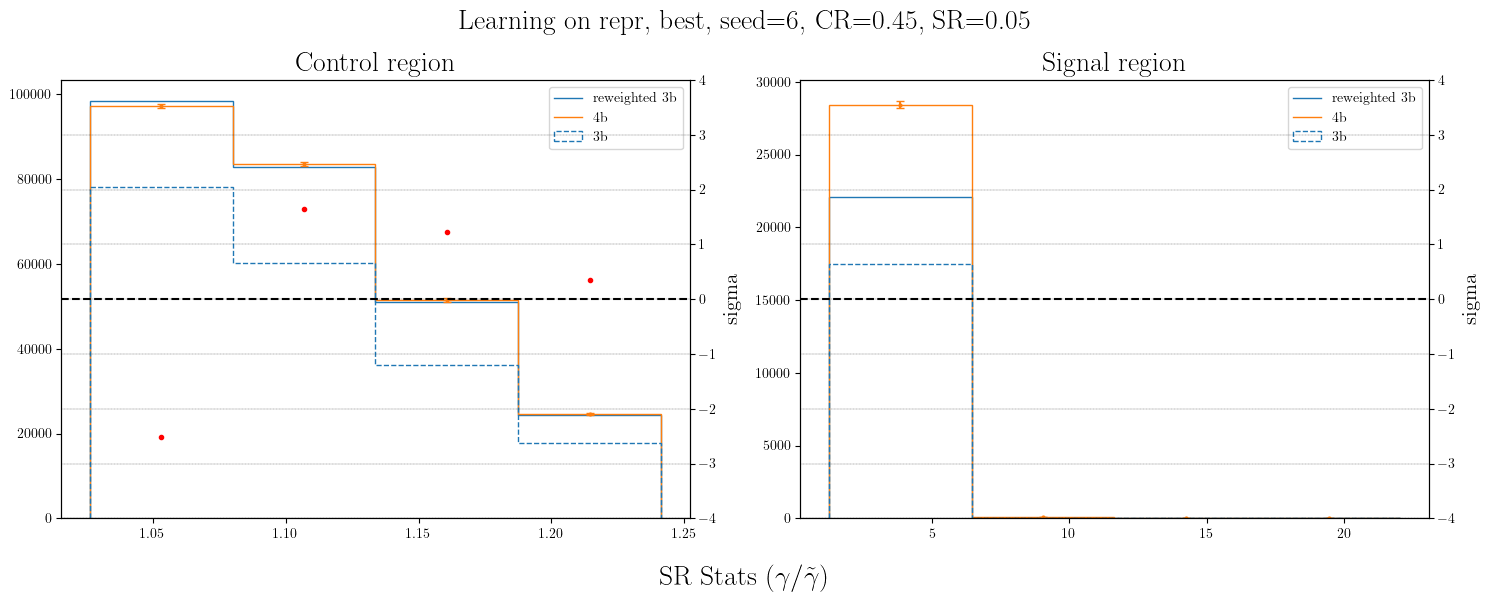

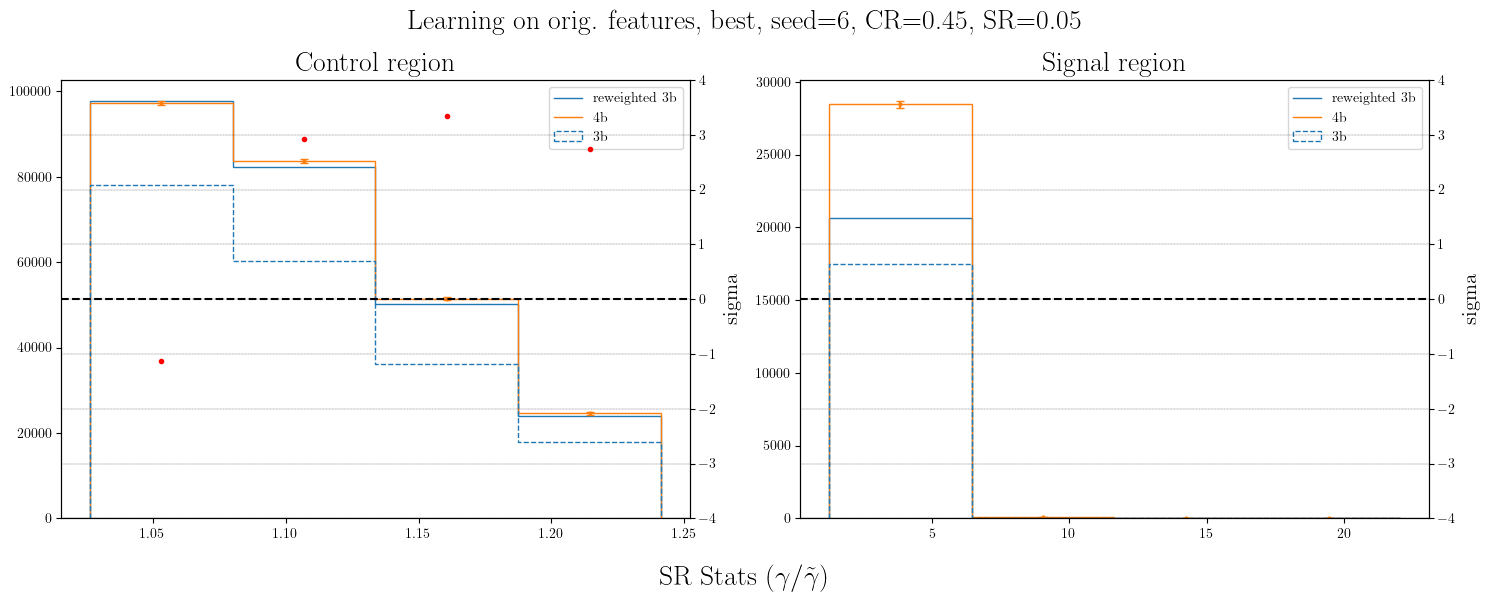

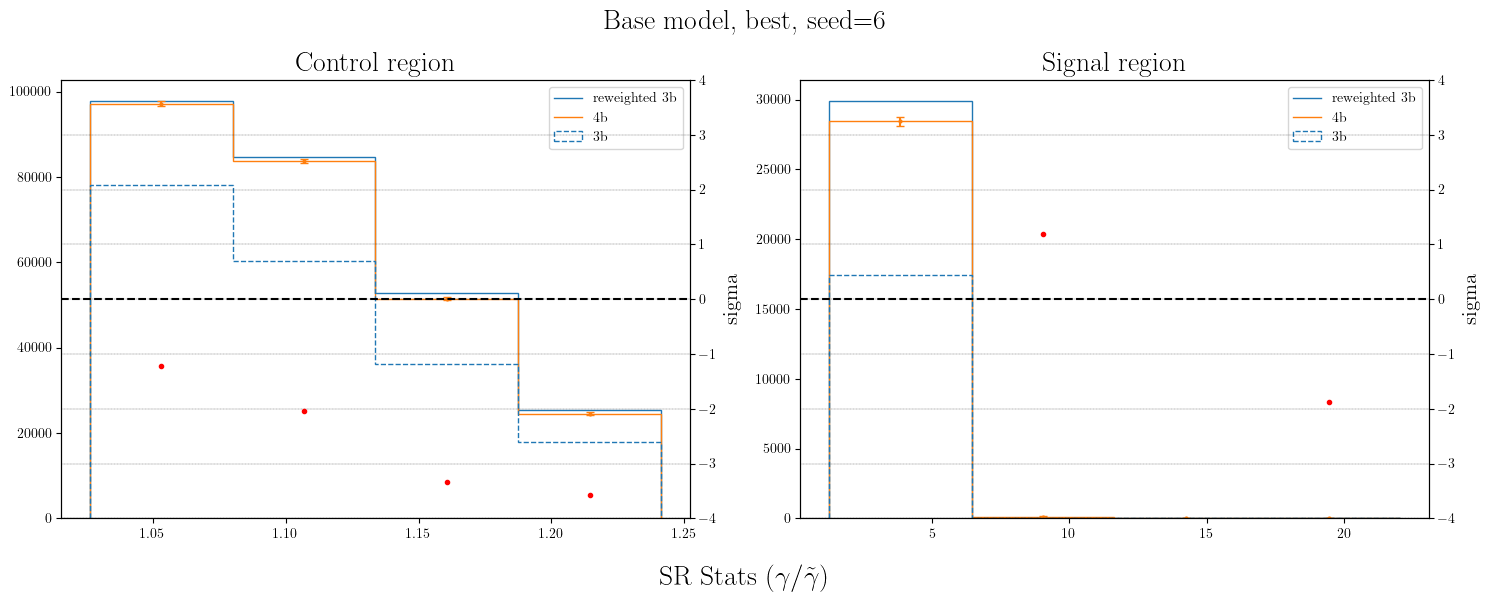

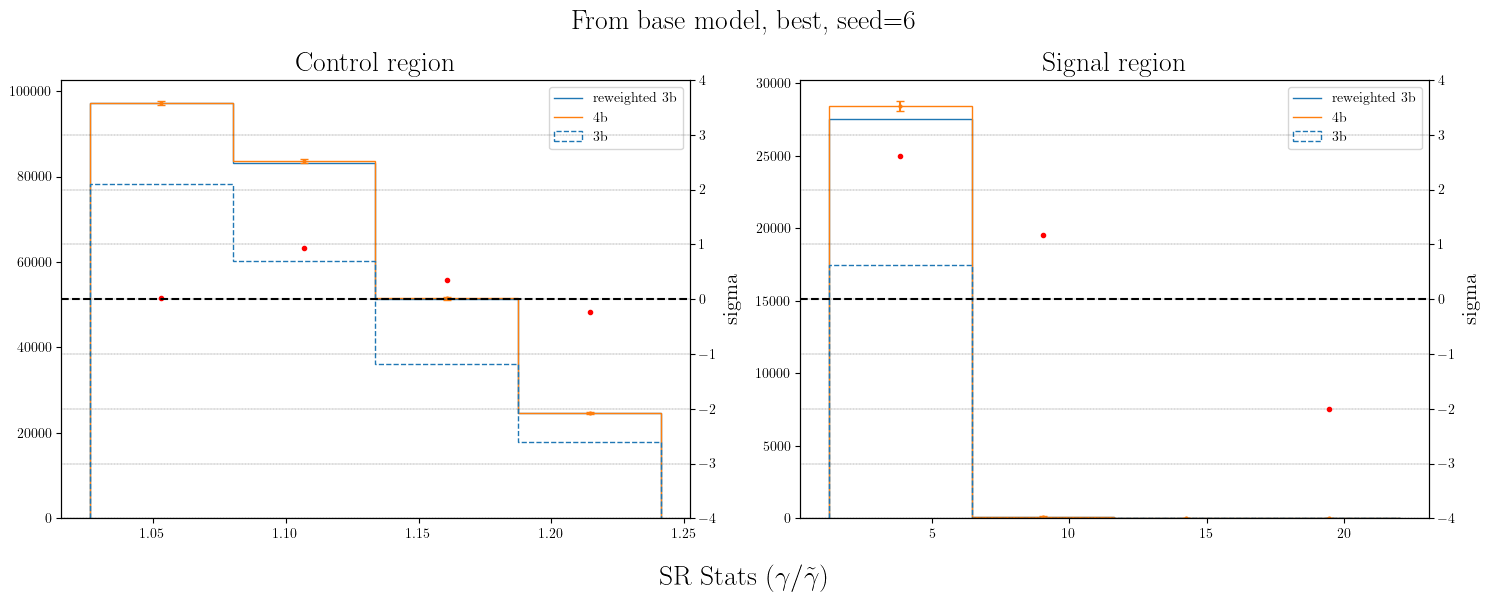

 67%|██████▋   | 2/3 [00:47<00:23, 23.89s/it]

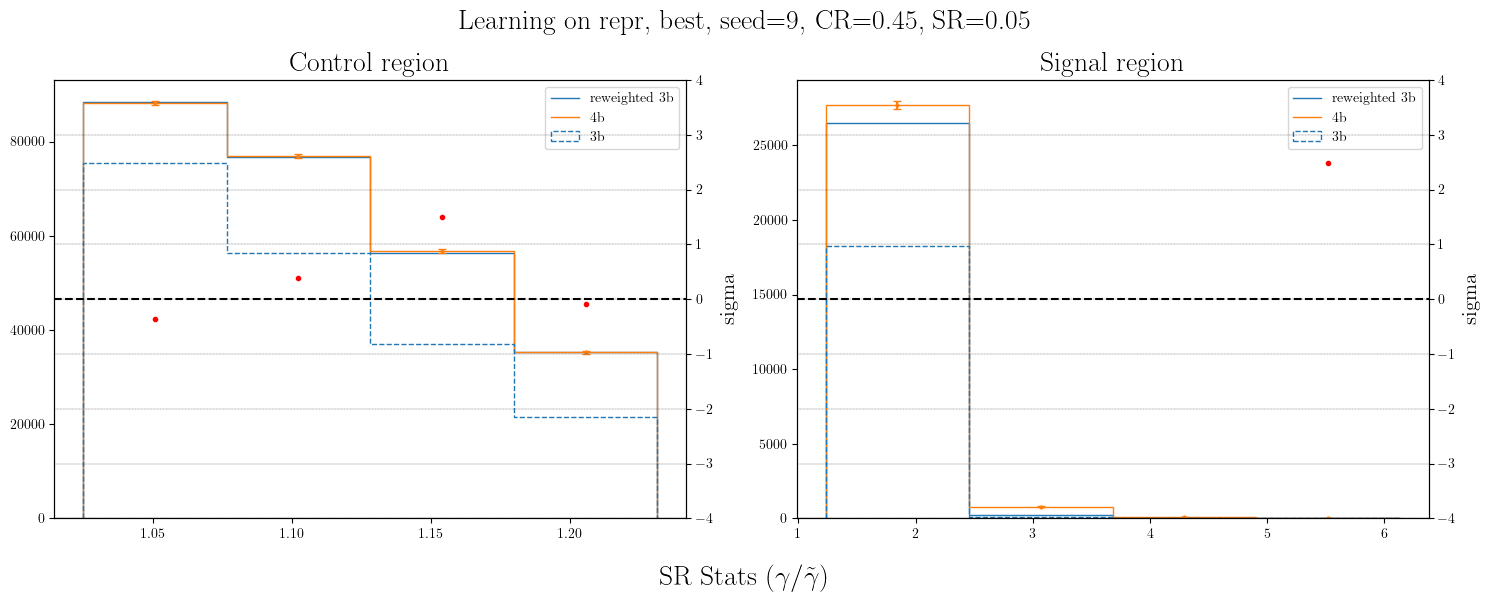

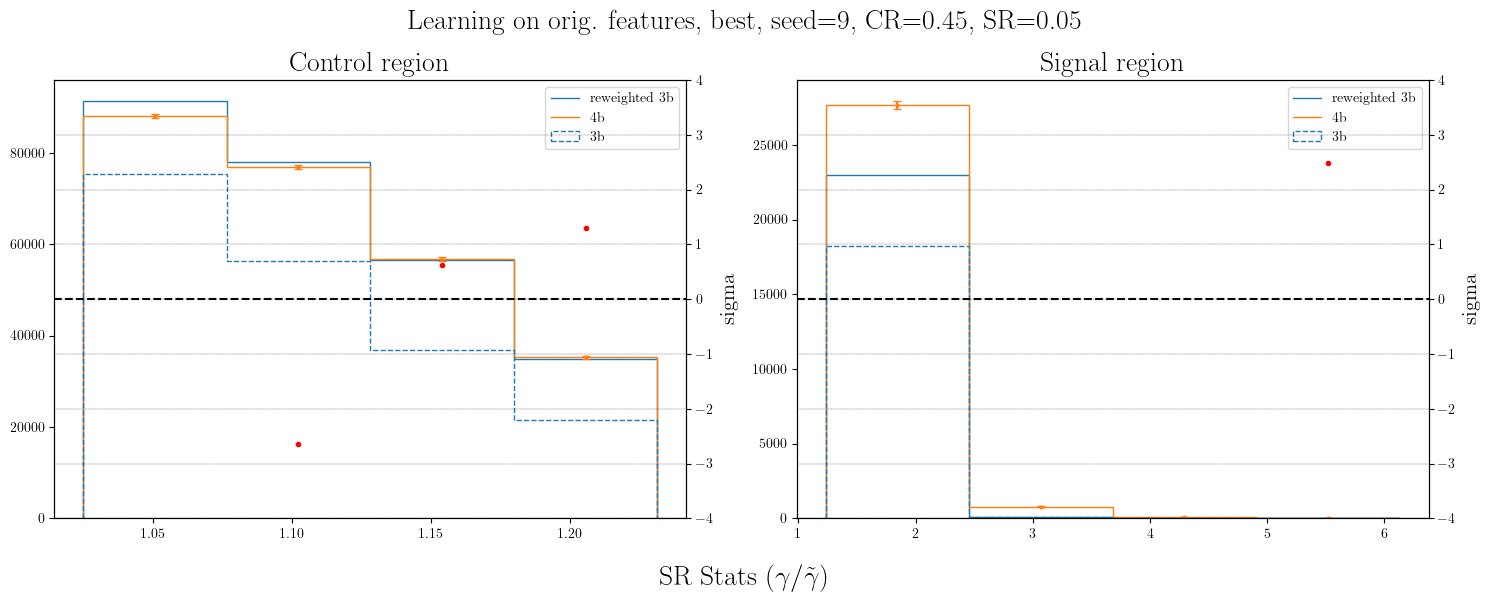

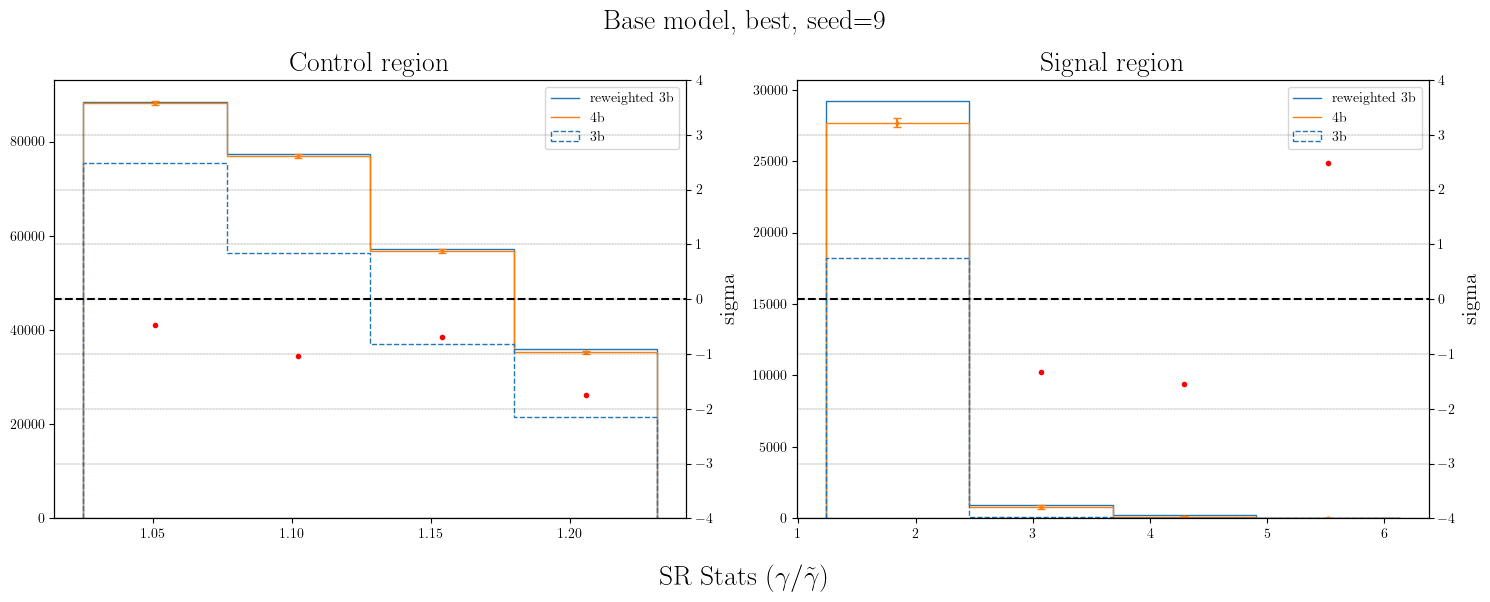

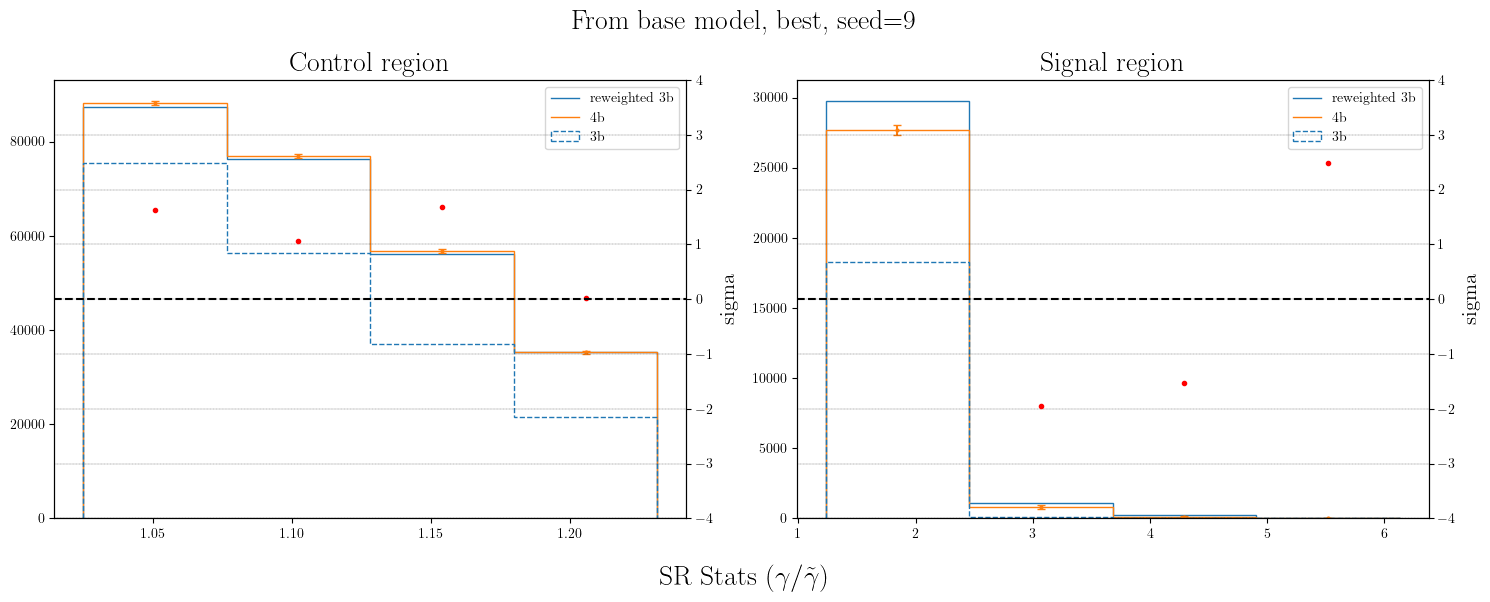

100%|██████████| 3/3 [01:11<00:00, 23.99s/it]


In [19]:
import time
import pytorch_lightning as pl
import yaml
from events_data import events_from_scdinfo
from dataset import MotherSamples
from training_info import TrainingInfo
from attention_classifier import AttentionClassifier
from plots import plot_sr_stats
import tqdm
from torch.utils.data import TensorDataset

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "smeared_fvt_training"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
seeds = [3, 6, 9]
signal_ratio = 0.02

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "dataset": lambda x: all([x["seed"] in seeds, 
                            x["n_3b"] == n_3b, 
                            x["signal_ratio"] == signal_ratio]),
    "model": "AttentionClassifier"
}
hashes = TrainingInfo.find(hparam_filter)

SRCR_hparams = {
    "4b_in_SR": 0.05,
    "4b_in_CR": 0.45
}
nbins = 5
cal_bins = np.linspace(0, 1, nbins)
quantiles = np.linspace(0, 1, nbins)

for tinfo_hash in tqdm.tqdm(hashes):
    smeared_tinfo = TrainingInfo.load(tinfo_hash)
    seed = smeared_tinfo.hparams["dataset"]["seed"]
    smeared_fvt = smeared_tinfo.load_trained_model("best")
    smeared_fvt.eval()
    smeared_fvt.to(device)
    
    base_tinfo = TrainingInfo.load(smeared_tinfo.hparams["encoder_hash"])
    loaded = torch.load(f"./data/checkpoints/{base_tinfo.hash}_best.ckpt")
    base_fvt = base_tinfo.load_trained_model("best")
    base_fvt.eval()
    base_fvt.to(device)
    
    msamples = MotherSamples.load(smeared_tinfo.ms_hash)
    tst_scdinfo = msamples.scdinfo[~smeared_tinfo.ms_idx]
    events_tst = events_from_scdinfo(tst_scdinfo, features, signal_filename)
    # Should not be shuffled
    
    probs_4b_base = base_fvt.predict(events_tst.X_torch)[:, 1].detach().cpu().numpy()
    q_repr_tst = base_fvt.representations(events_tst.X_torch)[0]
    probs_4b_smeared = smeared_fvt.predict(q_repr_tst)[:, 1].detach().cpu().numpy()
    gamma_base = probs_4b_base / (1 - probs_4b_base)
    gamma_smeared = probs_4b_smeared / (1 - probs_4b_smeared)
    
    SR_stats = gamma_base / gamma_smeared
    
    SR_cut, CR_cut = get_SR_CR_cut(SR_stats, events_tst, SRCR_hparams)
    
    SR_idx = (SR_stats >= SR_cut)
    CR_idx = (SR_stats >= CR_cut) & (SR_stats < SR_cut)
    
    events_tst_SR = events_tst[SR_idx]
    events_tst_CR = events_tst[CR_idx]
    
    q_repr_tst_SR = base_fvt.representations(events_tst_SR.X_torch)[0]
    q_repr_tst_CR = base_fvt.representations(events_tst_CR.X_torch)[0]
    
    # for mode in ["best", "last"]:
    for mode in ["best"]:
        CR_fvt = FvTClassifier.load_from_checkpoint(f"./data/tmp/checkpoints/CR_fvt_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_signal_ratio_{signal_ratio}_{mode}.ckpt")
        CR_fvt.eval()
        CR_fvt.to(device)
        
        CR_fvt_from_base = FvTClassifier.load_from_checkpoint(f"./data/tmp/checkpoints/CR_fvt_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_signal_ratio_{signal_ratio}_from_base_model_{mode}.ckpt")
        CR_fvt_from_base.eval()
        CR_fvt_from_base.to(device)
        
        CR_att_clf = AttentionClassifier.load_from_checkpoint(f"./data/tmp/checkpoints/CR_att_clf_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_signal_ratio_{signal_ratio}_{mode}.ckpt")
        CR_att_clf.eval()
        CR_att_clf.to(device)
    
    
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"Learning on repr, {mode}, seed={seed}, CR={SRCR_hparams['4b_in_CR']}, SR={SRCR_hparams['4b_in_SR']}")
        fig.supxlabel(fr"SR Stats ($\gamma / \tilde\gamma$)")
        ax[0].set_title(f"Control region")
        ax[1].set_title(f"Signal region")

        fvt_scores_SR = CR_att_clf.predict(q_repr_tst_SR)[:, 1].detach().cpu().numpy()
        fvt_scores_CR = CR_att_clf.predict(q_repr_tst_CR)[:, 1].detach().cpu().numpy()
        
        # CR_cal_bins = np.quantile(SR_stats[CR_idx], quantiles)
        # SR_cal_bins = np.quantile(SR_stats[SR_idx], quantiles)
        CR_cal_bins = np.linspace(np.min(SR_stats[CR_idx]), np.max(SR_stats[CR_idx]), nbins)
        SR_cal_bins = np.linspace(np.min(SR_stats[SR_idx]), np.max(SR_stats[SR_idx]), nbins)

        plot_rewighted_samples_by_model(events_tst_CR,
                                        x_values=SR_stats[CR_idx],
                                        fvt_scores=fvt_scores_CR,
                                        bins=CR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[0],
                                        )
        ax[0].hist(SR_stats[CR_idx][events_tst_CR.is_3b], bins=CR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_CR.weights[events_tst_CR.is_3b])
        ax[0].legend()

        plot_rewighted_samples_by_model(events_tst_SR,
                                        x_values=SR_stats[SR_idx],
                                        fvt_scores=fvt_scores_SR,
                                        bins=SR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[1],
                                        )
        ax[1].hist(SR_stats[SR_idx][events_tst_SR.is_3b], bins=SR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_SR.weights[events_tst_SR.is_3b])
        ax[1].legend()

        plt.tight_layout()
        # plt.savefig(f"./data/plots/Learning on repr, {mode}_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_SR_stats.pdf", dpi=300)
        plt.show()
        plt.close("all")
        
        # fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        # fig.suptitle(f"Learning on repr, {mode}, seed={seed}, CR={SRCR_hparams['4b_in_CR']}, SR={SRCR_hparams['4b_in_SR']}")
        # fig.supxlabel(fr"FvT score (prob 4b)")
        # ax[0].set_title(f"Control region")
        # ax[1].set_title(f"Signal region")
        
        # CR_cal_bins = np.linspace(np.min(fvt_scores_CR), np.max(fvt_scores_CR), nbins)
        # SR_cal_bins = np.linspace(np.min(fvt_scores_SR), np.max(fvt_scores_SR), nbins)

        # plot_rewighted_samples_by_model(events_tst_CR,
        #                                 x_values=fvt_scores_CR,
        #                                 fvt_scores=fvt_scores_CR,
        #                                 bins=CR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[0],
        #                                 )
        # ax[0].hist(fvt_scores_CR[events_tst_CR.is_3b], bins=CR_cal_bins, label="3b", histtype="step", linestyle="--", 
        #         weights=events_tst_CR.weights[events_tst_CR.is_3b])
        # ax[0].legend()

        # plot_rewighted_samples_by_model(events_tst_SR,
        #                                 x_values=fvt_scores_SR,
        #                                 fvt_scores=fvt_scores_SR,
        #                                 bins=SR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[1],
        #                                 )
        # ax[1].hist(fvt_scores_SR[events_tst_SR.is_3b], bins=SR_cal_bins, label="3b", histtype="step", linestyle="--", 
        #         weights=events_tst_SR.weights[events_tst_SR.is_3b])
        # ax[1].legend()

        # plt.tight_layout()
        # # plt.savefig(f"./data/plots/Learning on repr, {mode}_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_FvT_score.pdf", dpi=300)
        # plt.show()
        # plt.close("all")

            
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"Learning on orig. features, {mode}, seed={seed}, CR={SRCR_hparams['4b_in_CR']}, SR={SRCR_hparams['4b_in_SR']}")
        fig.supxlabel(fr"SR Stats ($\gamma / \tilde\gamma$)")
        ax[0].set_title(f"Control region")
        ax[1].set_title(f"Signal region")

        fvt_scores_SR = CR_fvt.predict(events_tst_SR.X_torch)[:, 1].detach().cpu().numpy()
        fvt_scores_CR = CR_fvt.predict(events_tst_CR.X_torch)[:, 1].detach().cpu().numpy()
        
        # CR_cal_bins = np.quantile(SR_stats[CR_idx], quantiles)
        # SR_cal_bins = np.quantile(SR_stats[SR_idx], quantiles)
        CR_cal_bins = np.linspace(np.min(SR_stats[CR_idx]), np.max(SR_stats[CR_idx]), nbins)
        SR_cal_bins = np.linspace(np.min(SR_stats[SR_idx]), np.max(SR_stats[SR_idx]), nbins)

        plot_rewighted_samples_by_model(events_tst_CR,
                                        x_values=SR_stats[CR_idx],
                                        fvt_scores=fvt_scores_CR,
                                        bins=CR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[0],
                                        )
        ax[0].hist(SR_stats[CR_idx][events_tst_CR.is_3b], bins=CR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_CR.weights[events_tst_CR.is_3b])
        ax[0].legend()

        plot_rewighted_samples_by_model(events_tst_SR,
                                        x_values=SR_stats[SR_idx],
                                        fvt_scores=fvt_scores_SR,
                                        bins=SR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[1],
                                        )
        ax[1].hist(SR_stats[SR_idx][events_tst_SR.is_3b], bins=SR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_SR.weights[events_tst_SR.is_3b])
        ax[1].legend()

        plt.tight_layout()
        # plt.savefig(f"./data/plots/Learning on orig. features, {mode}_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_SR_stats.pdf", dpi=300)
        plt.show()
        plt.close("all")
        
        # fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        # fig.suptitle(f"Learning on orig. features, {mode}, seed={seed}, CR={SRCR_hparams['4b_in_CR']}, SR={SRCR_hparams['4b_in_SR']}")
        # fig.supxlabel(fr"FvT score (prob 4b)")
        # ax[0].set_title(f"Control region")
        # ax[1].set_title(f"Signal region")
        
        # CR_cal_bins = np.linspace(np.min(fvt_scores_CR), np.max(fvt_scores_CR), nbins)
        # SR_cal_bins = np.linspace(np.min(fvt_scores_SR), np.max(fvt_scores_SR), nbins)

        # plot_rewighted_samples_by_model(events_tst_CR,
        #                                 x_values=fvt_scores_CR,
        #                                 fvt_scores=fvt_scores_CR,
        #                                 bins=CR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[0],
        #                                 )
        # ax[0].hist(fvt_scores_CR[events_tst_CR.is_3b], bins=CR_cal_bins, label="3b", histtype="step", linestyle="--", 
        #         weights=events_tst_CR.weights[events_tst_CR.is_3b])
        # ax[0].legend()

        # plot_rewighted_samples_by_model(events_tst_SR,
        #                                 x_values=fvt_scores_SR,
        #                                 fvt_scores=fvt_scores_SR,
        #                                 bins=SR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[1],
        #                                 )
        # ax[1].hist(fvt_scores_SR[events_tst_SR.is_3b], bins=SR_cal_bins, label="3b", histtype="step", linestyle="--", 
        #         weights=events_tst_SR.weights[events_tst_SR.is_3b])
        # ax[1].legend()

        # plt.tight_layout()
        # # plt.savefig(f"./data/plots/Learning on orig. features, {mode}_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_FvT_score.pdf", dpi=300)
        # plt.show()
        # plt.close("all")
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"Base model, {mode}, seed={seed}")
        fig.supxlabel(fr"SR Stats ($\gamma / \tilde\gamma$)")
        ax[0].set_title(f"Control region")
        ax[1].set_title(f"Signal region")
        
        CR_cal_bins = np.linspace(np.min(SR_stats[CR_idx]), np.max(SR_stats[CR_idx]), nbins)
        SR_cal_bins = np.linspace(np.min(SR_stats[SR_idx]), np.max(SR_stats[SR_idx]), nbins)

        plot_rewighted_samples_by_model(events_tst_CR,
                                        x_values=SR_stats[CR_idx],
                                        fvt_scores=probs_4b_base[CR_idx],
                                        bins=CR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[0],
                                        )
        ax[0].hist(SR_stats[CR_idx][events_tst_CR.is_3b], bins=CR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_CR.weights[events_tst_CR.is_3b])
        ax[0].legend()

        plot_rewighted_samples_by_model(events_tst_SR,
                                        x_values=SR_stats[SR_idx],
                                        fvt_scores=probs_4b_base[SR_idx],
                                        bins=SR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[1],
                                        )
        ax[1].hist(SR_stats[SR_idx][events_tst_SR.is_3b], bins=SR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_SR.weights[events_tst_SR.is_3b])
        ax[1].legend()

        plt.tight_layout()
        # plt.savefig(f"./data/plots/Learning on orig. features, {mode}_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_FvT_score.pdf", dpi=300)
        plt.show()
        plt.close("all")
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"From base model, {mode}, seed={seed}")
        fig.supxlabel(fr"SR Stats ($\gamma / \tilde\gamma$)")
        ax[0].set_title(f"Control region")
        ax[1].set_title(f"Signal region")
        
        CR_cal_bins = np.linspace(np.min(SR_stats[CR_idx]), np.max(SR_stats[CR_idx]), nbins)
        SR_cal_bins = np.linspace(np.min(SR_stats[SR_idx]), np.max(SR_stats[SR_idx]), nbins)
        
        fvt_scores_SR = CR_fvt_from_base.predict(events_tst_SR.X_torch)[:, 1].detach().cpu().numpy()
        fvt_scores_CR = CR_fvt_from_base.predict(events_tst_CR.X_torch)[:, 1].detach().cpu().numpy()

        plot_rewighted_samples_by_model(events_tst_CR,
                                        x_values=SR_stats[CR_idx],
                                        fvt_scores=fvt_scores_CR,
                                        bins=CR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[0],
                                        )
        ax[0].hist(SR_stats[CR_idx][events_tst_CR.is_3b], bins=CR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_CR.weights[events_tst_CR.is_3b])
        ax[0].legend()

        plot_rewighted_samples_by_model(events_tst_SR,
                                        x_values=SR_stats[SR_idx],
                                        fvt_scores=fvt_scores_SR,
                                        bins=SR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[1],
                                        )
        ax[1].hist(SR_stats[SR_idx][events_tst_SR.is_3b], bins=SR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_SR.weights[events_tst_SR.is_3b])
        ax[1].legend()

        plt.tight_layout()
        # plt.savefig(f"./data/plots/Learning on orig. features, {mode}_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_FvT_score.pdf", dpi=300)
        plt.show()
        plt.close("all")
        

  0%|          | 0/10 [00:00<?, ?it/s]

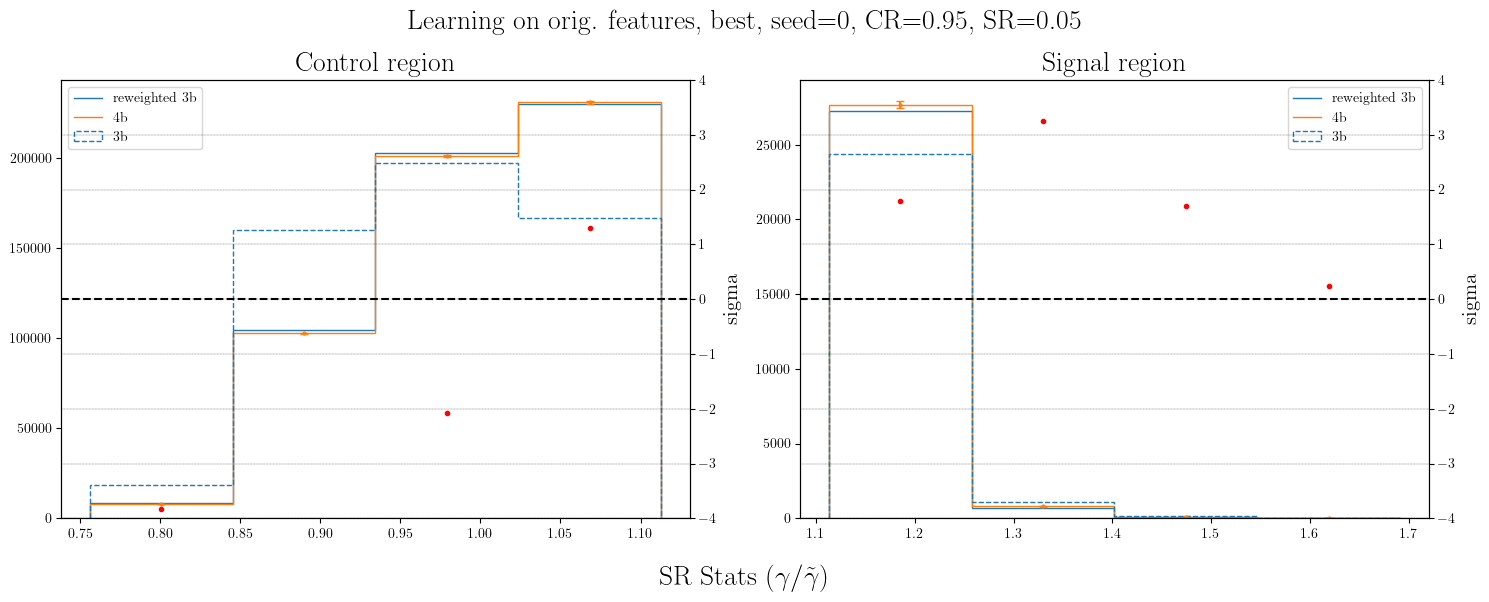

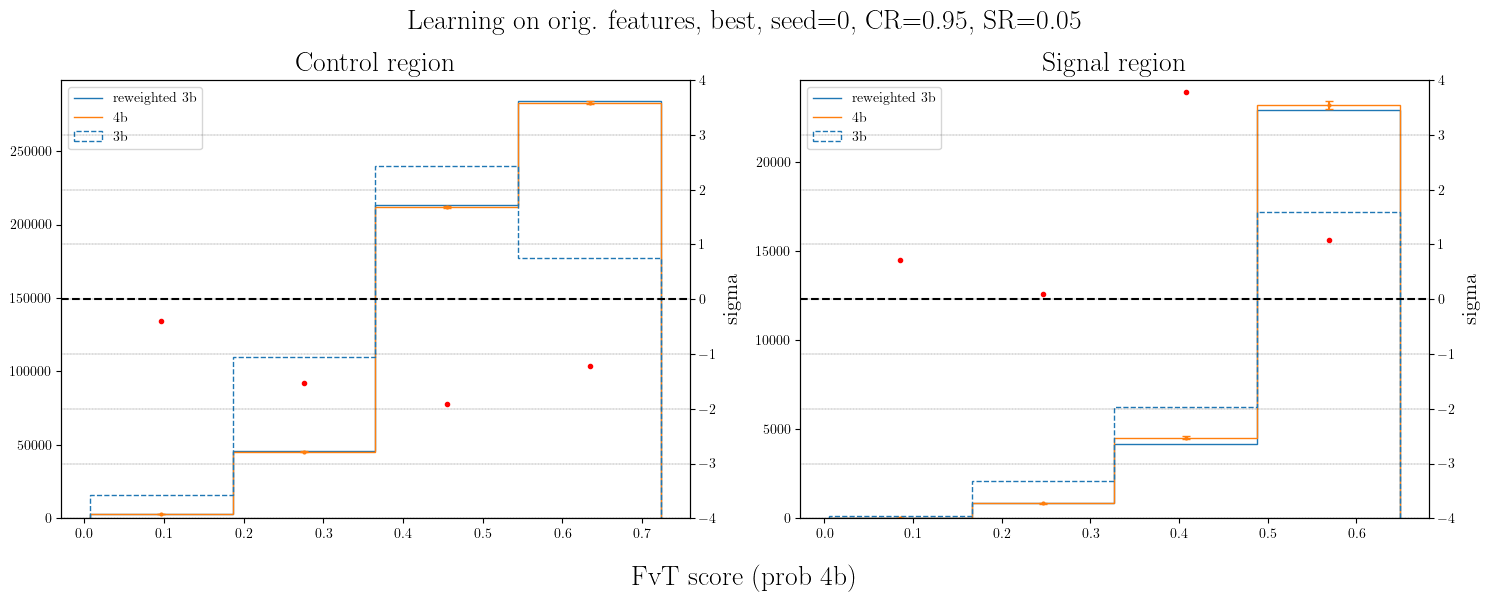

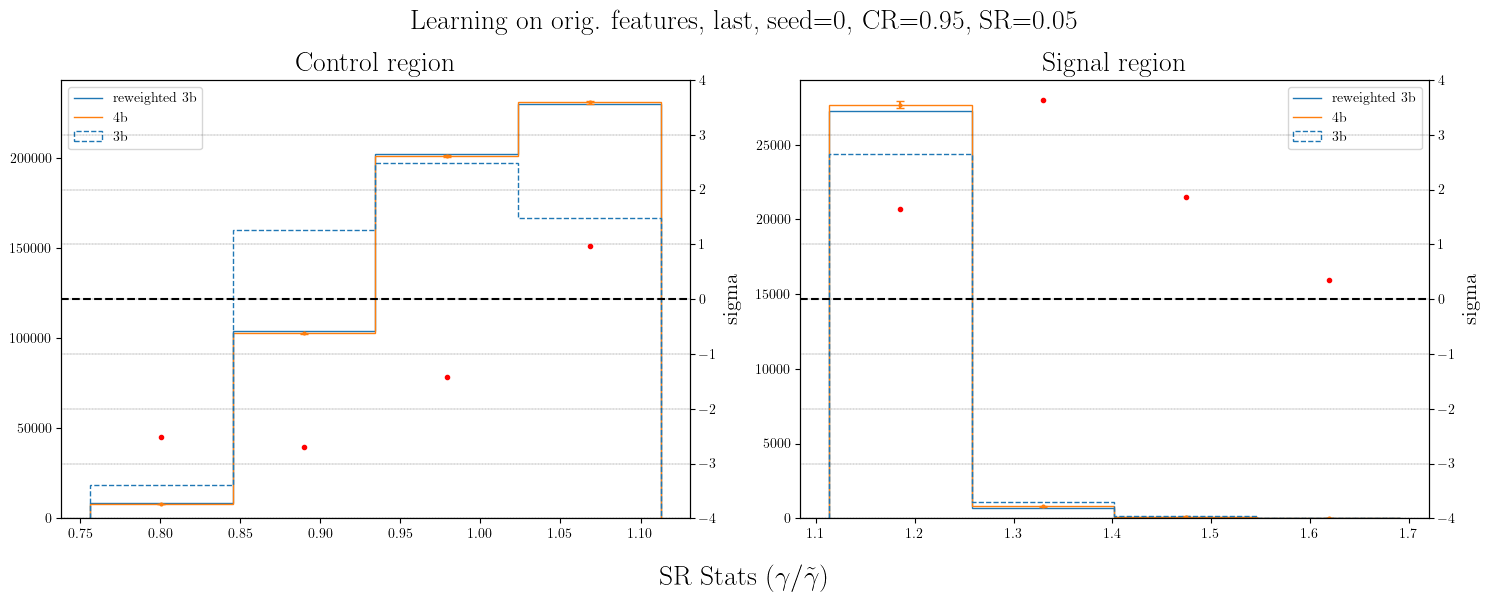

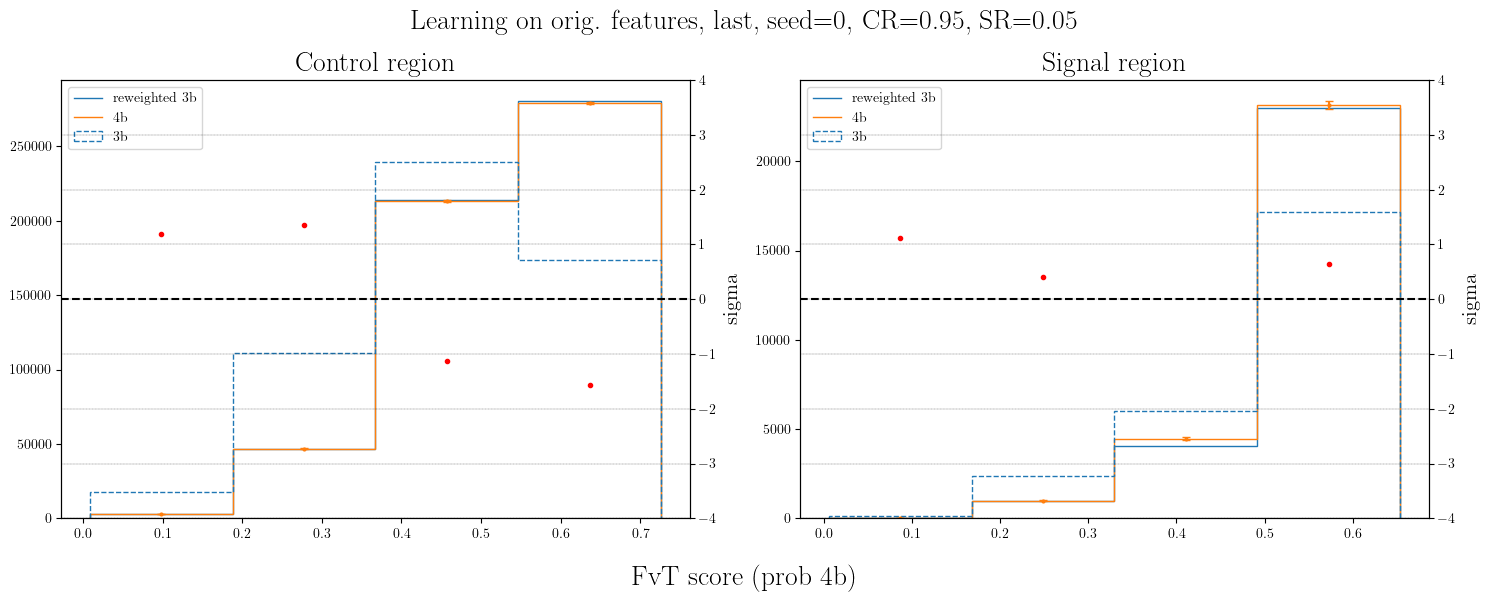

 10%|█         | 1/10 [00:26<04:01, 26.80s/it]

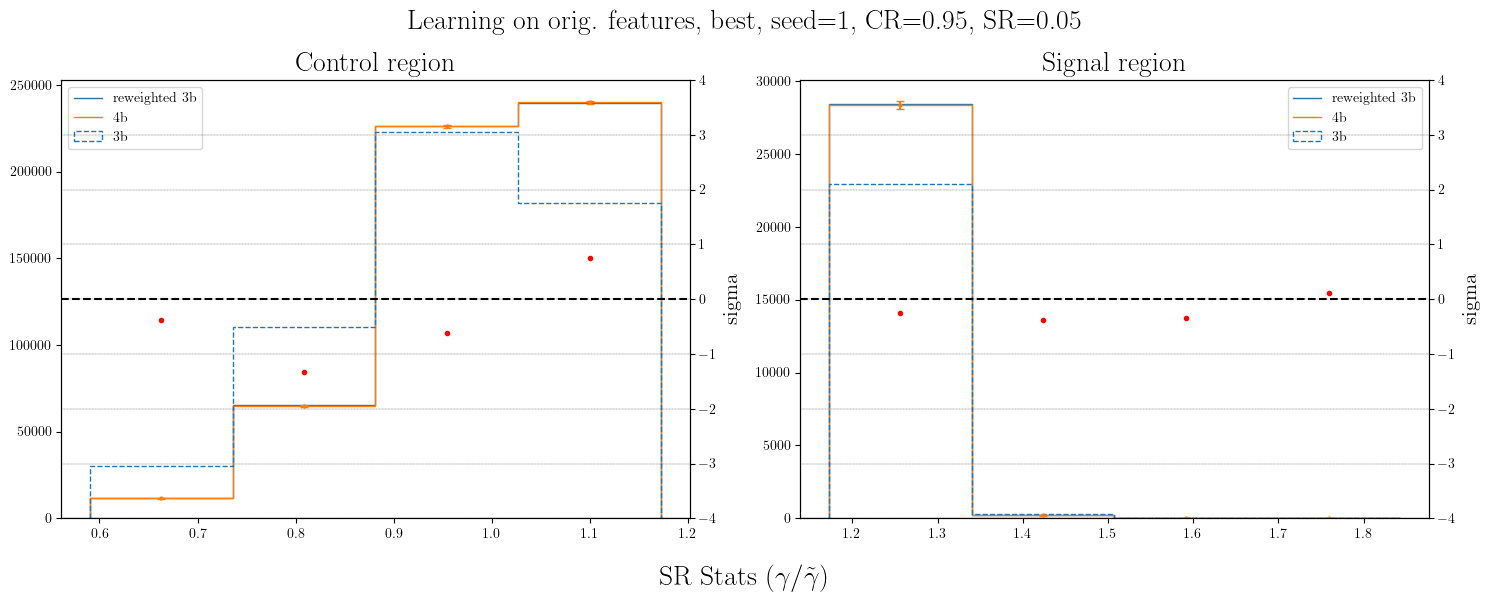

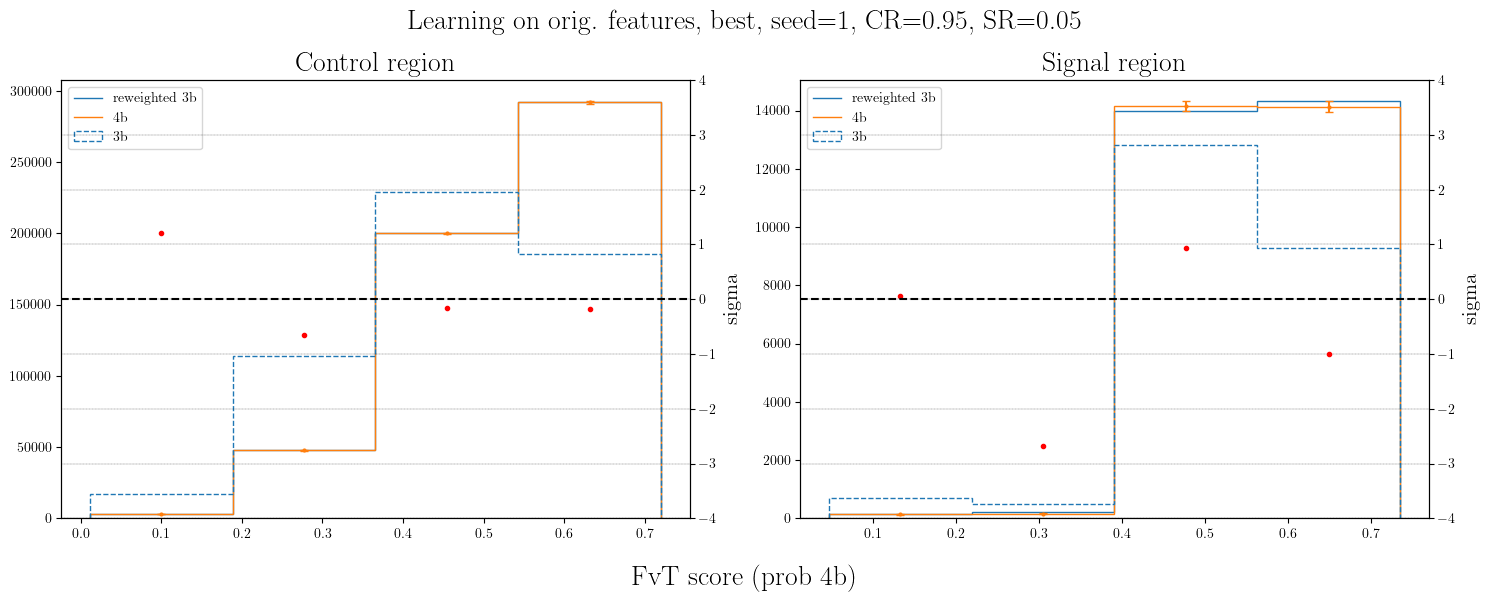

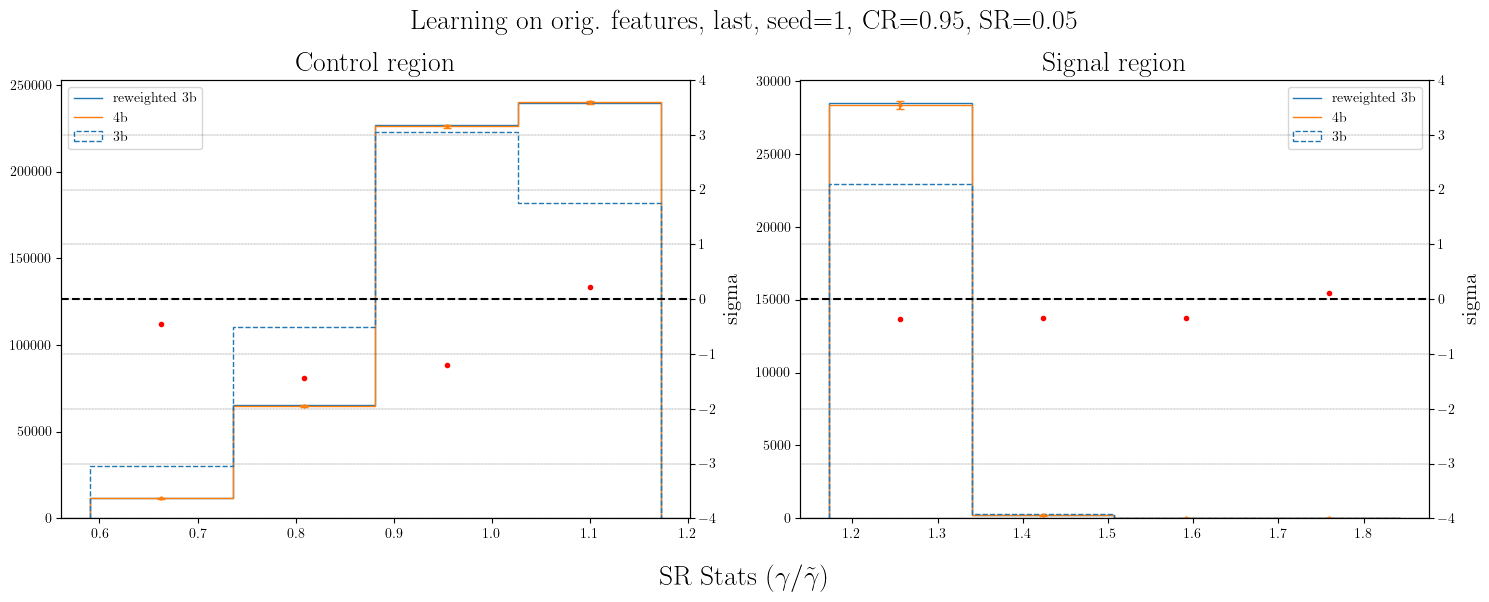

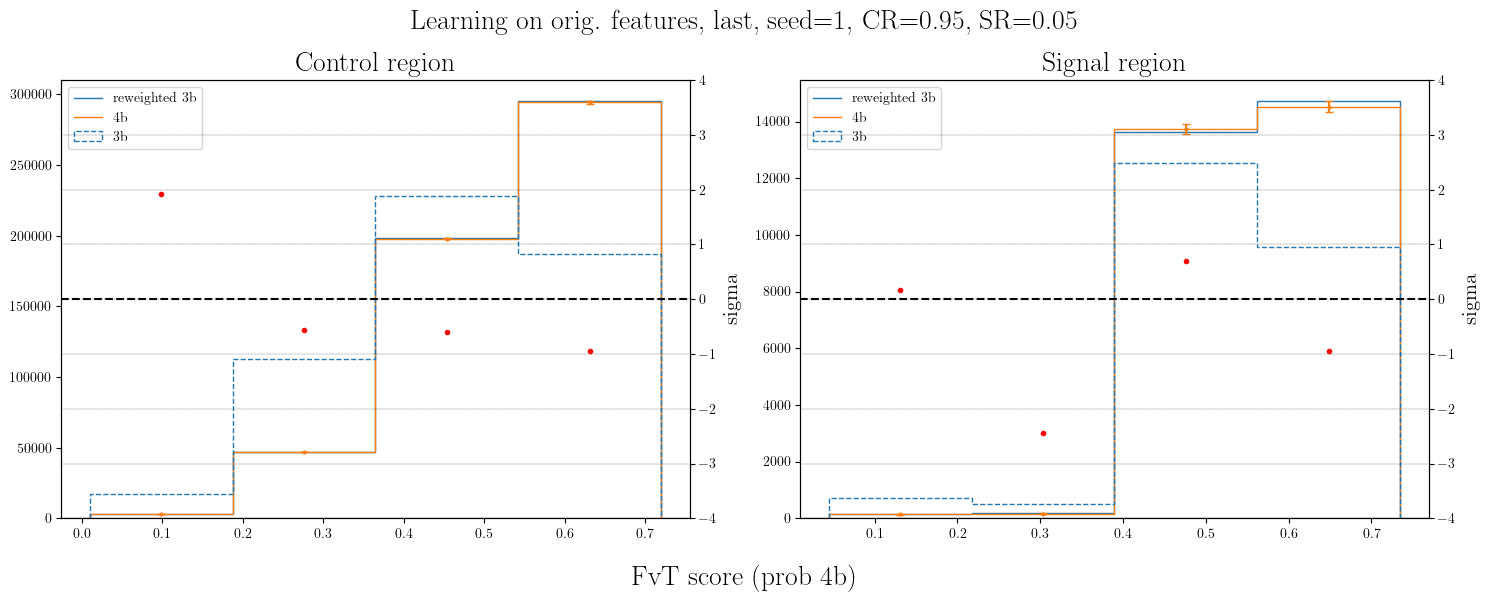

 20%|██        | 2/10 [00:53<03:32, 26.57s/it]

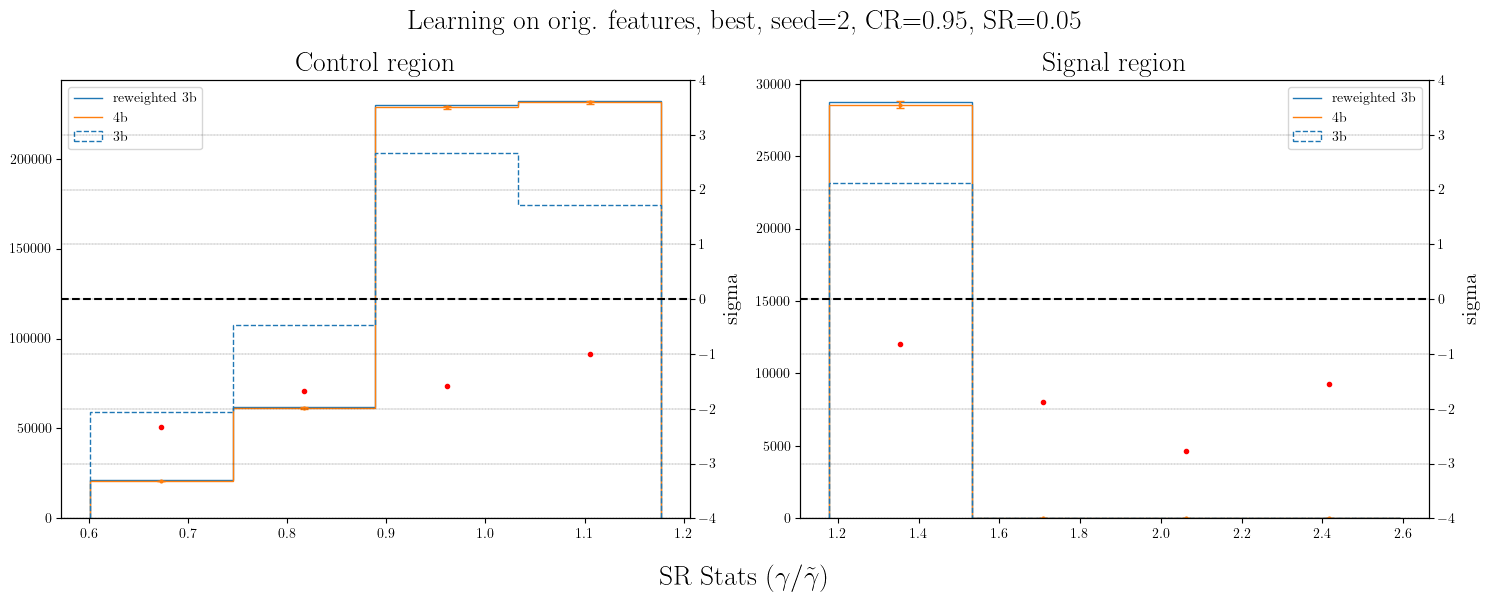

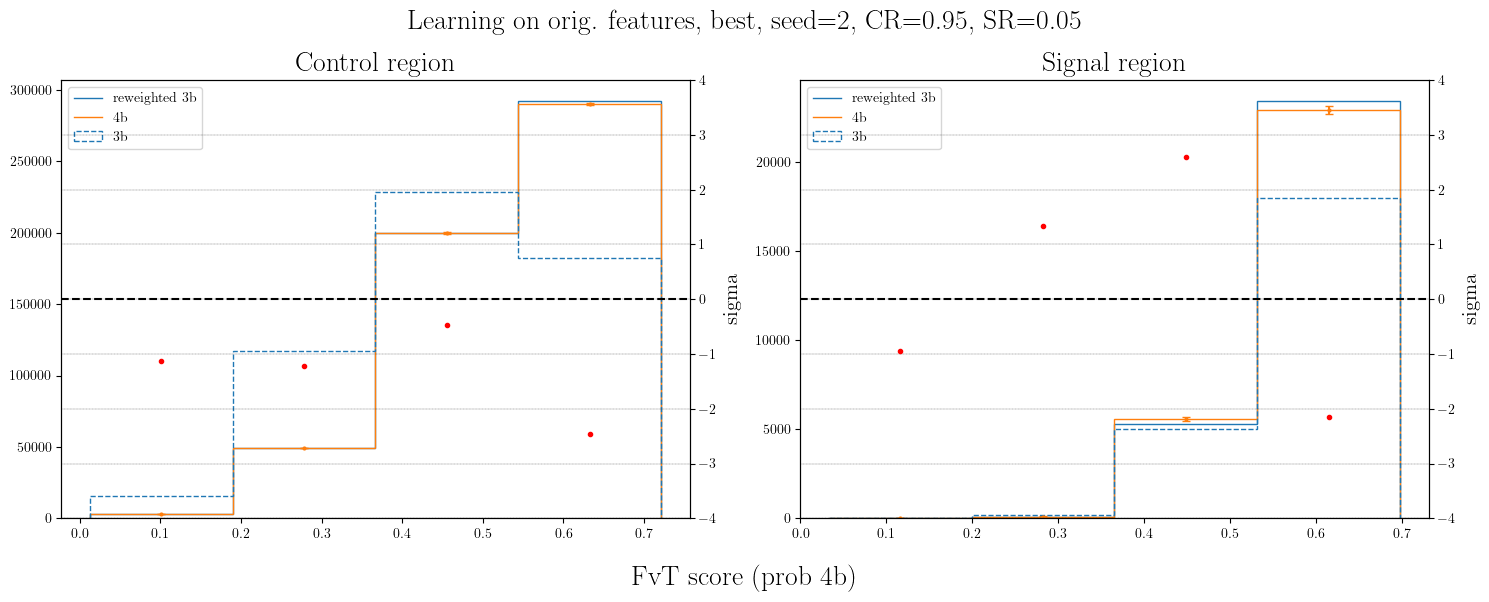

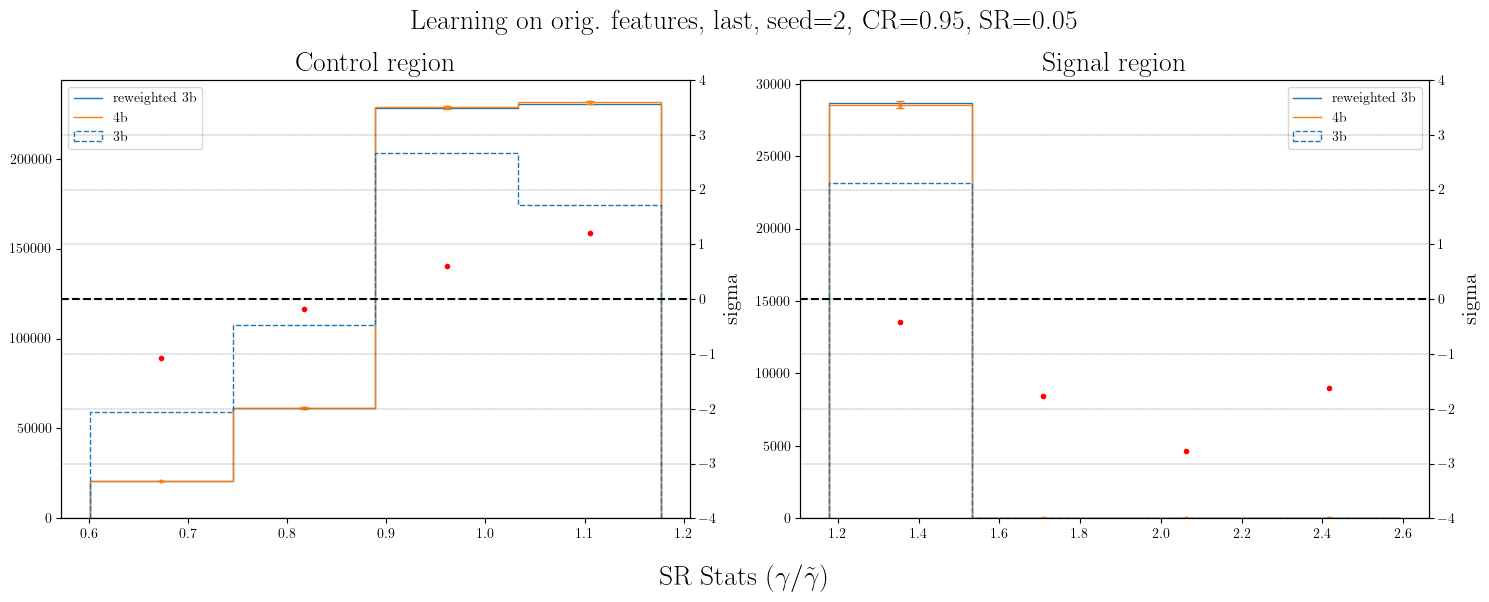

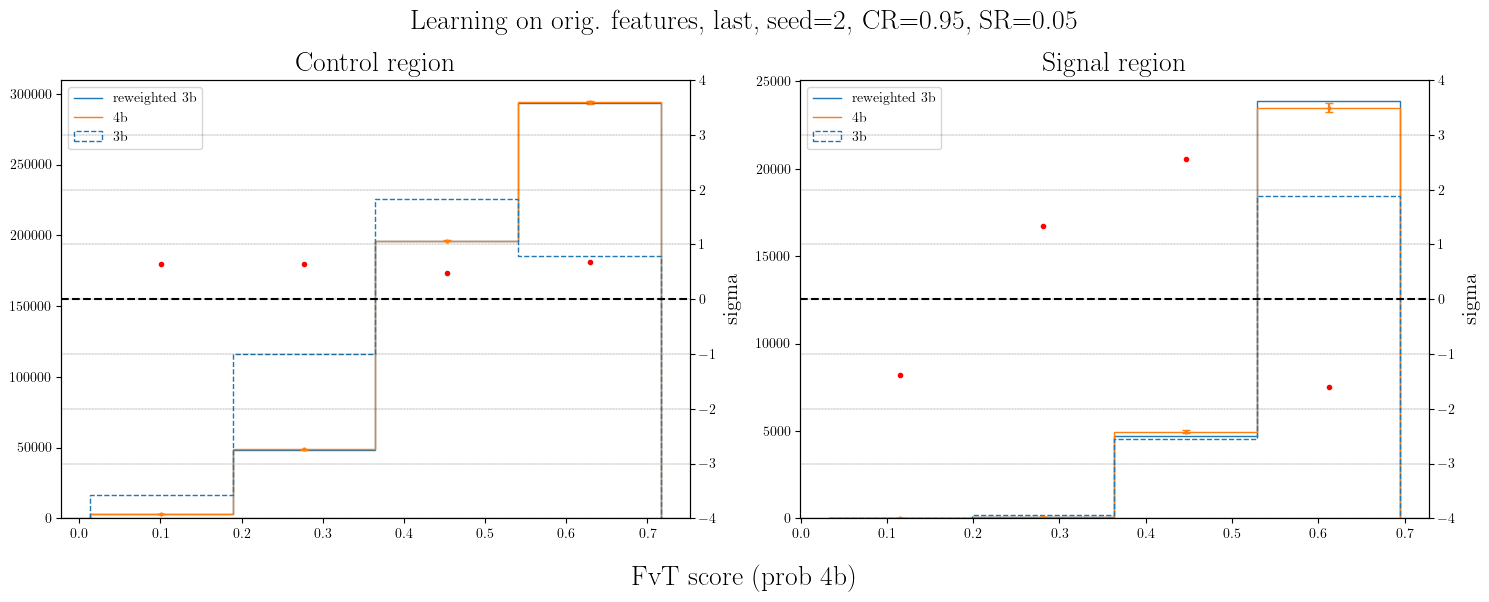

 30%|███       | 3/10 [01:19<03:05, 26.53s/it]

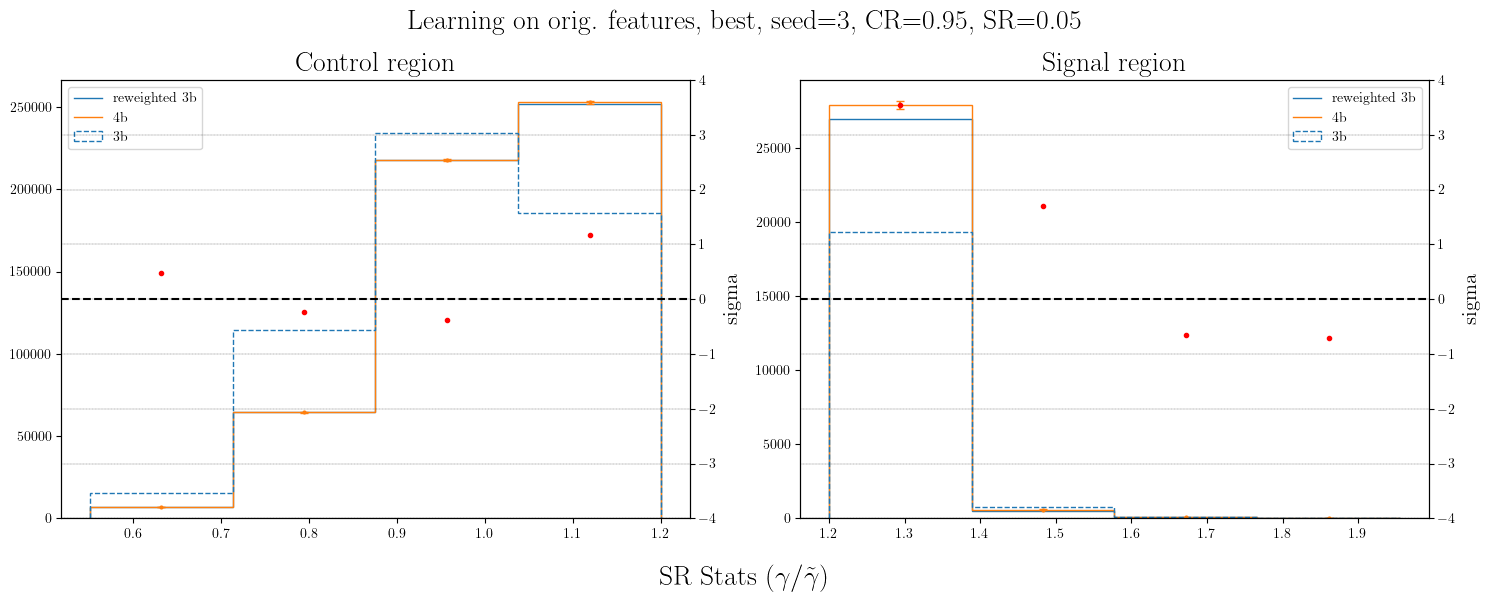

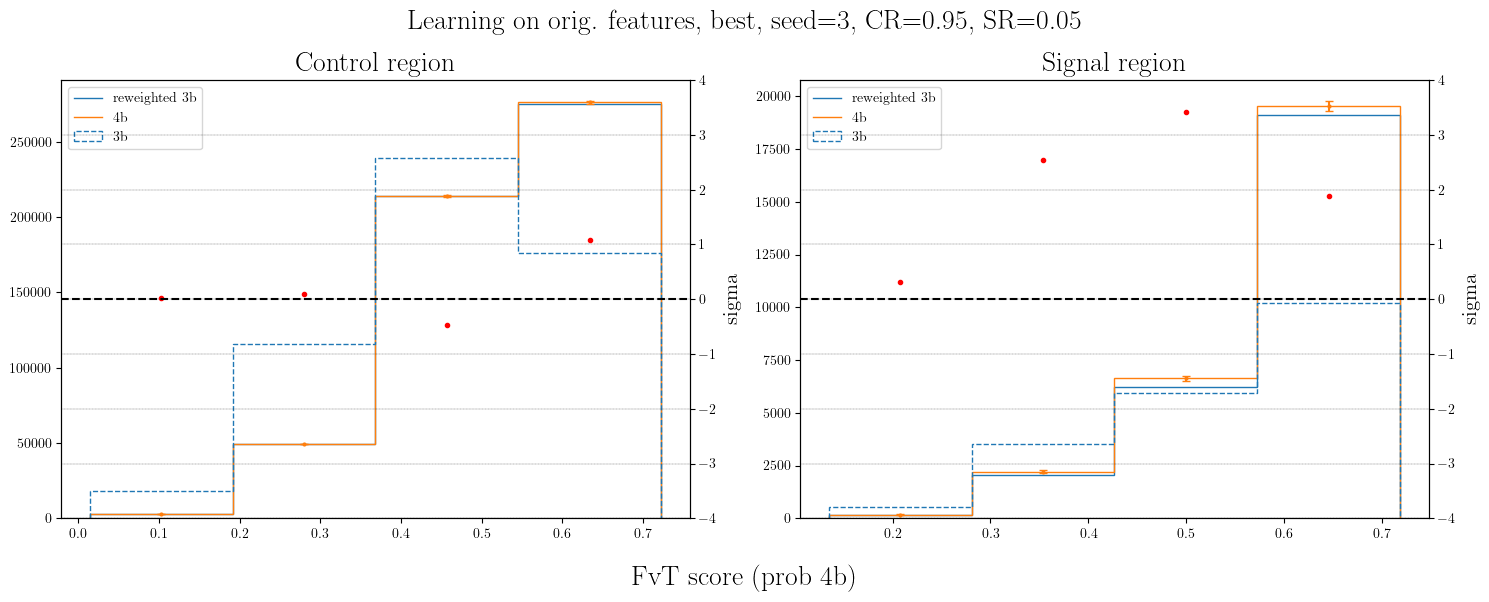

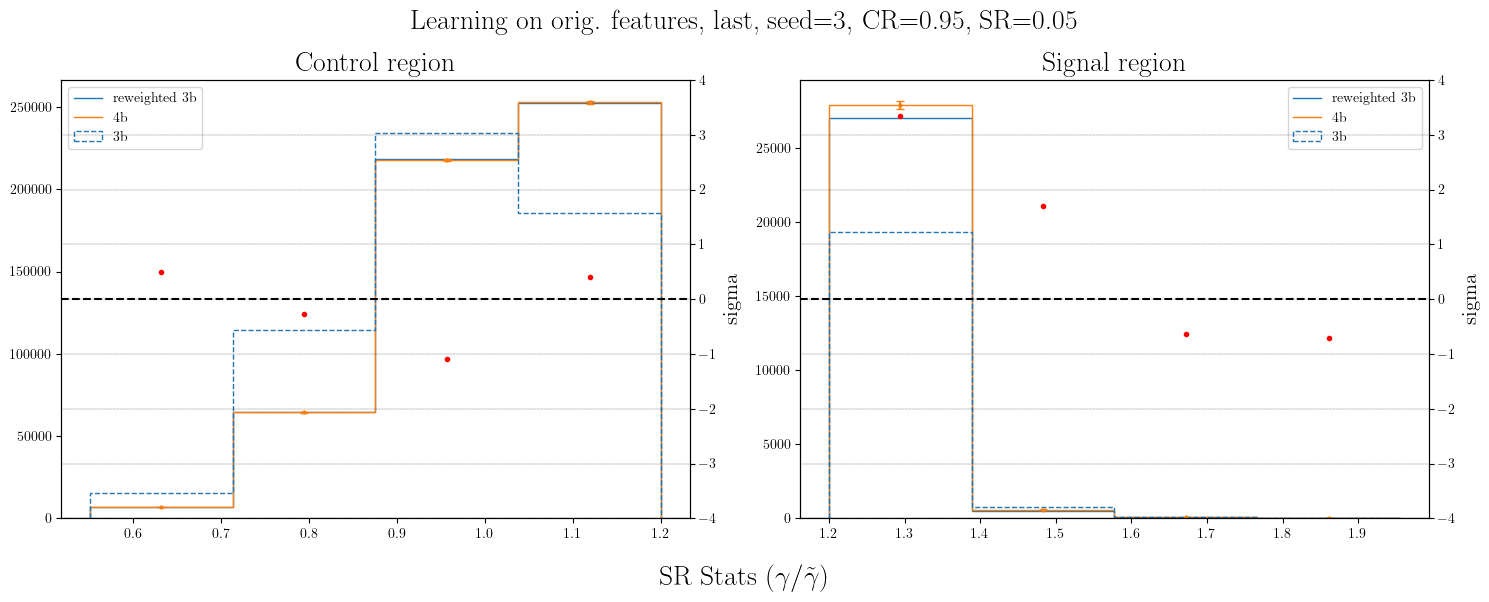

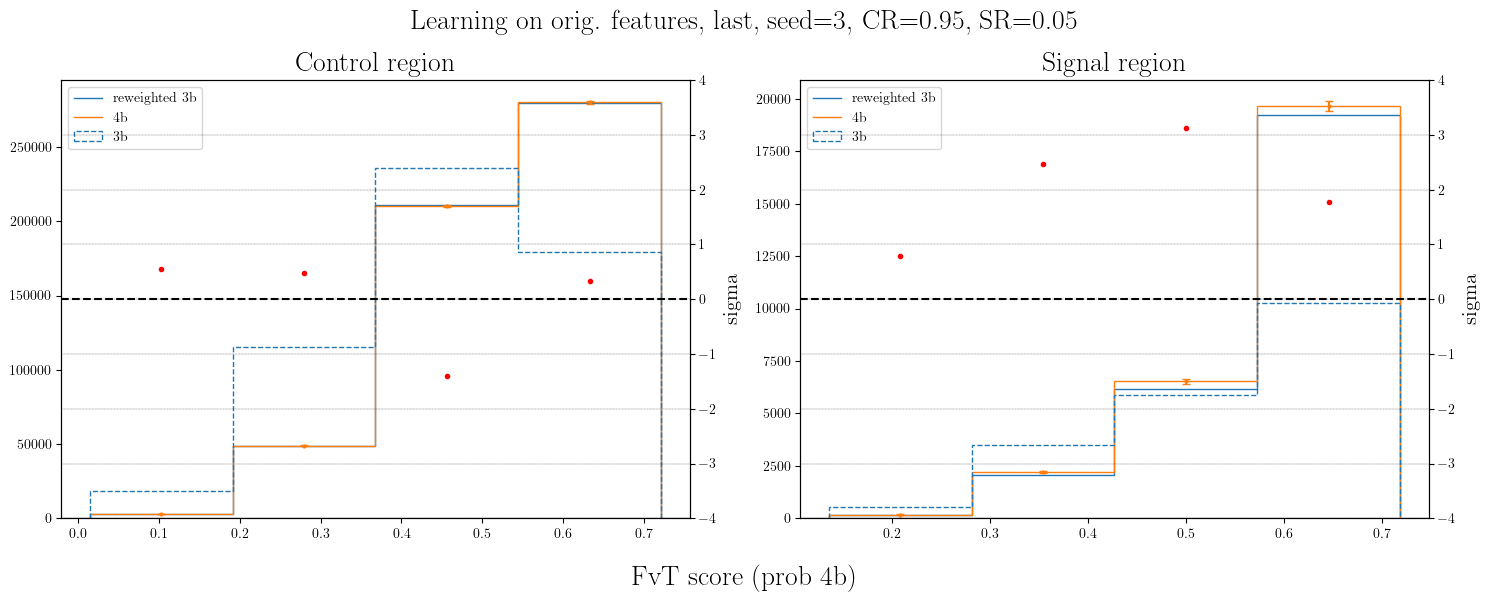

 40%|████      | 4/10 [01:46<02:40, 26.82s/it]

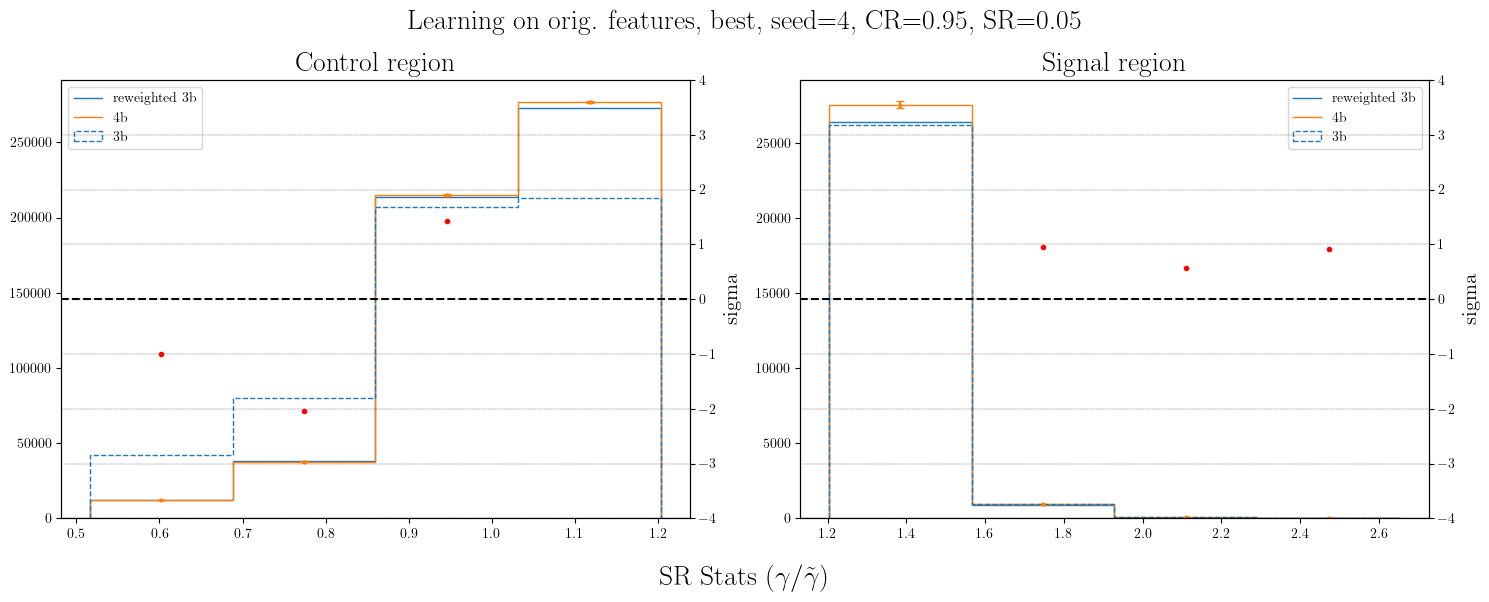

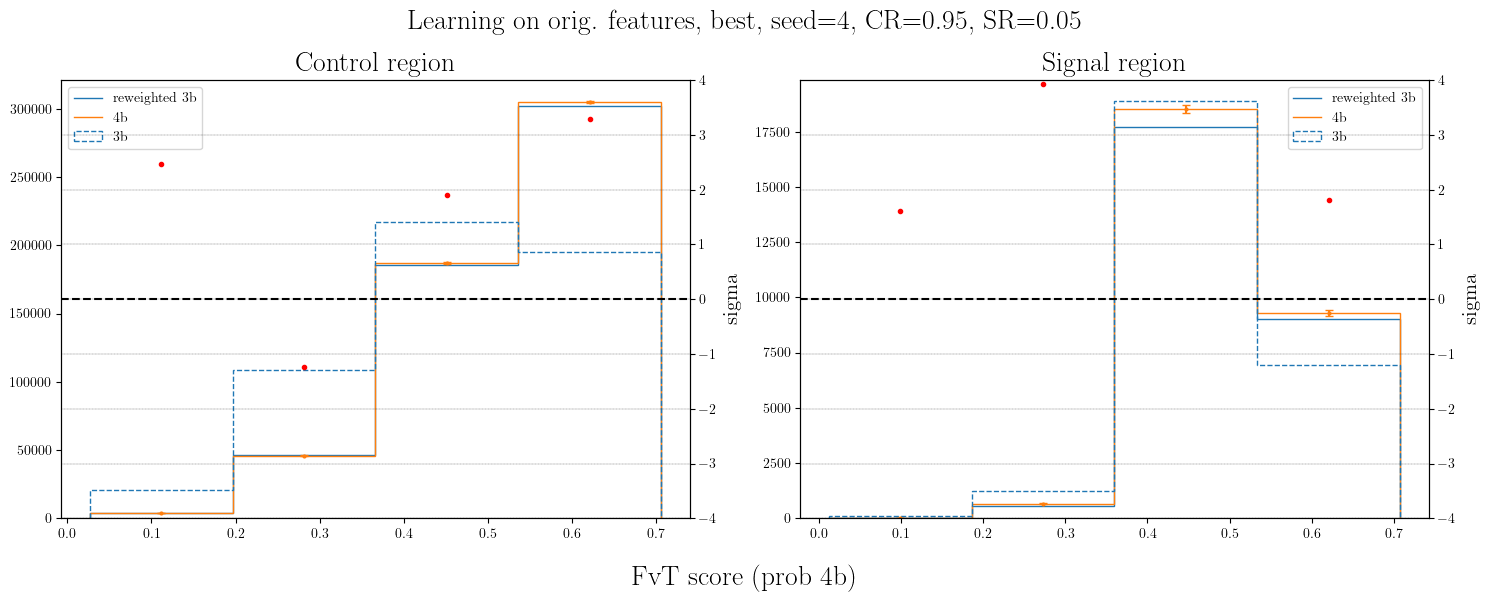

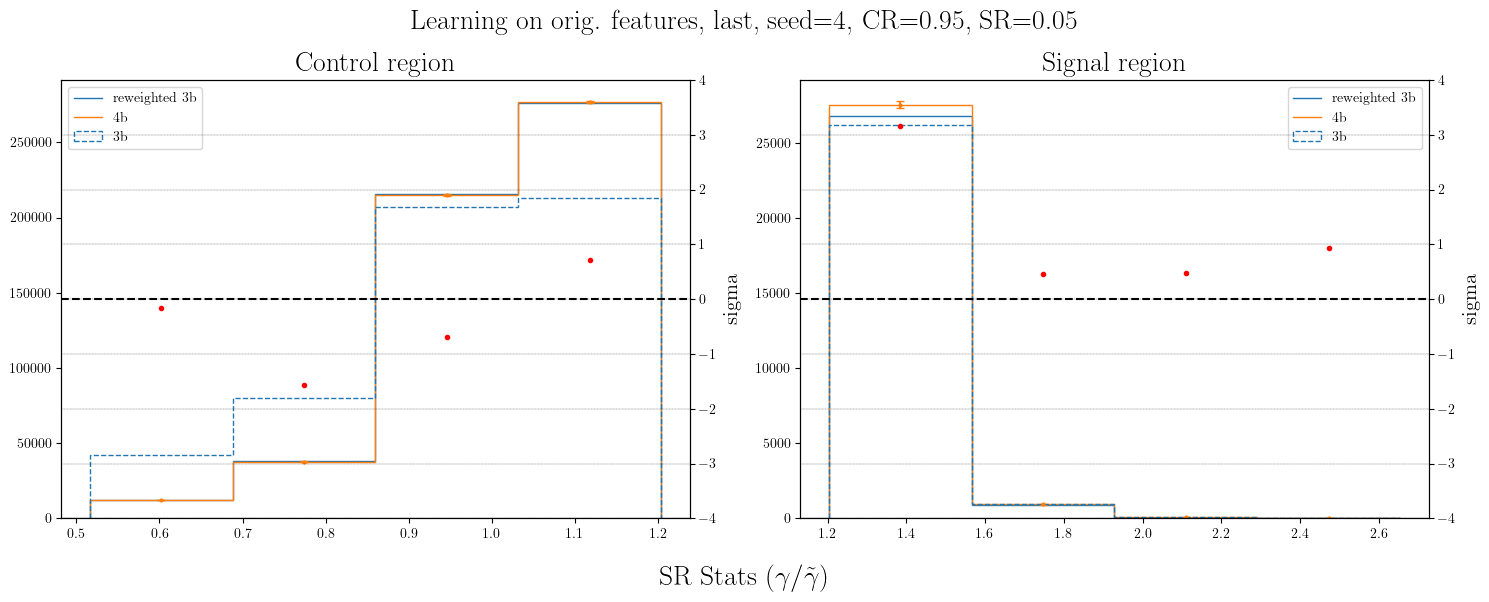

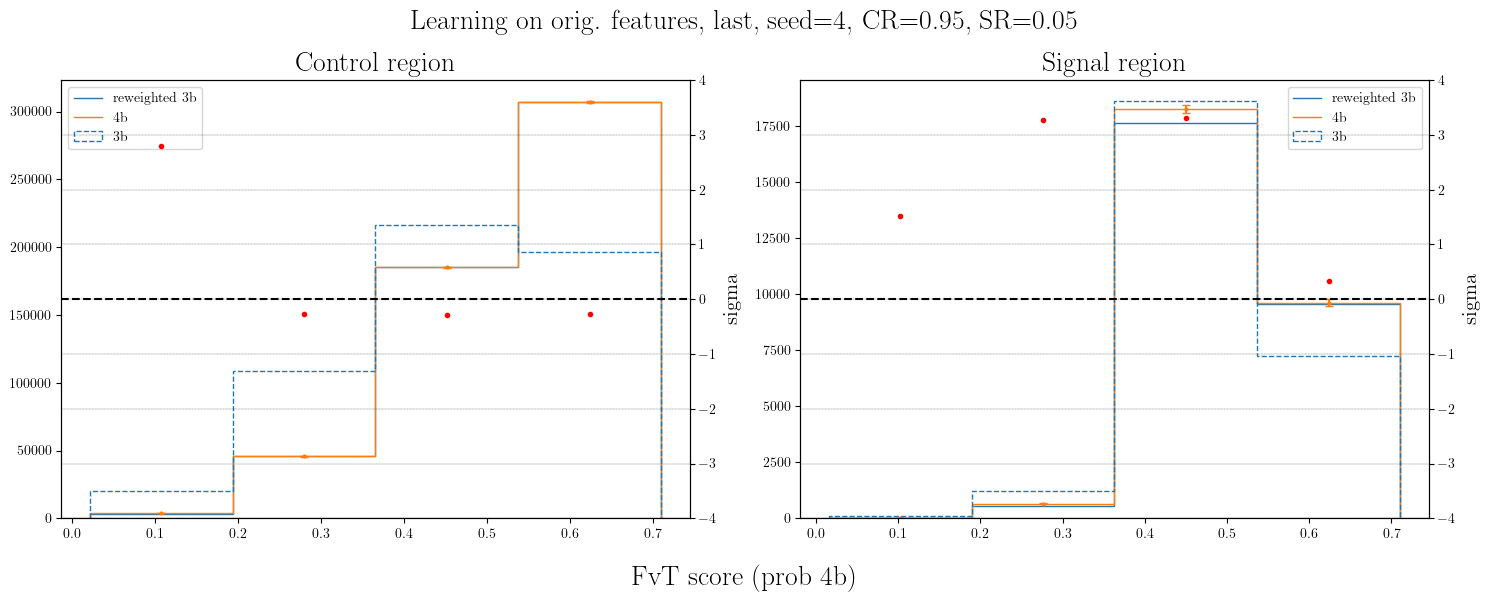

 50%|█████     | 5/10 [02:14<02:14, 26.91s/it]

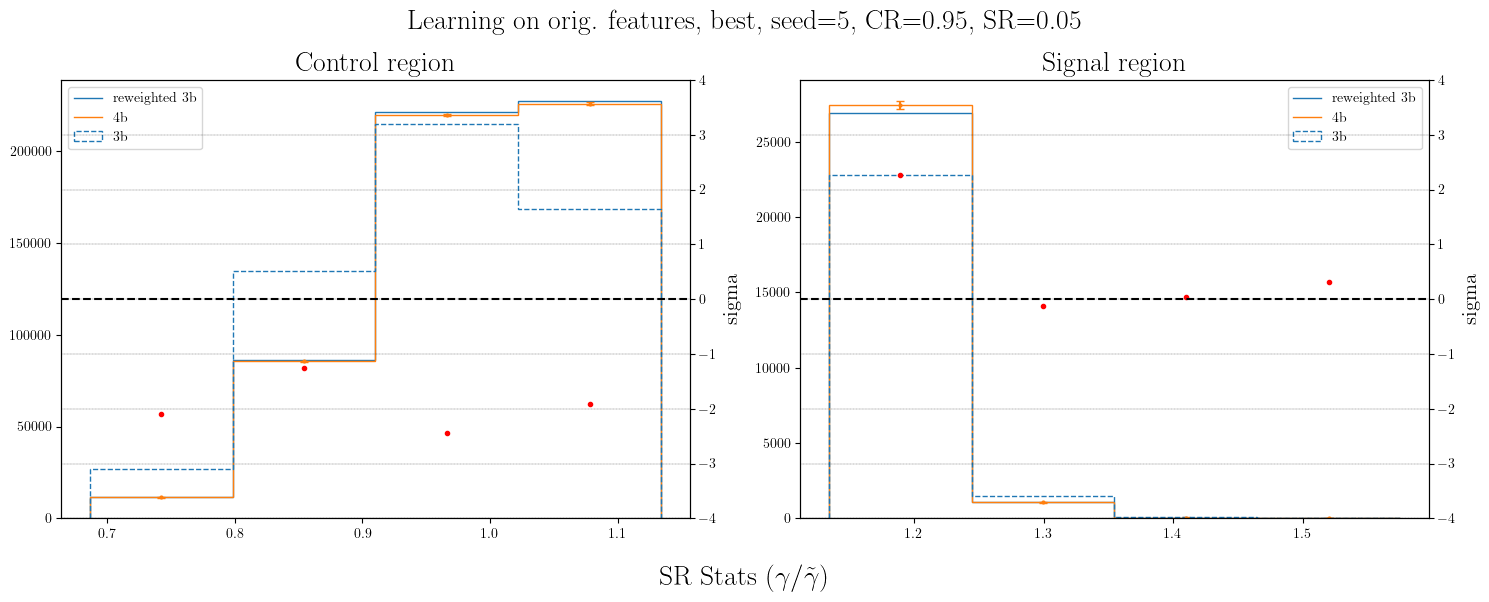

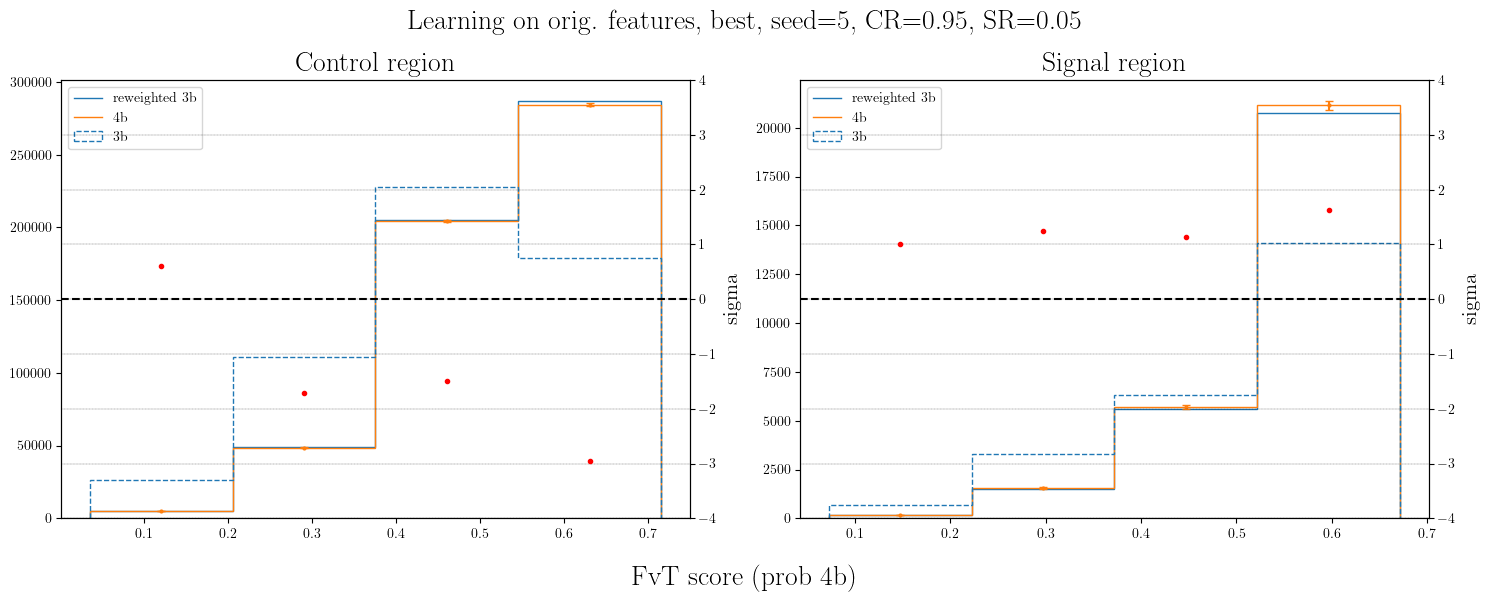

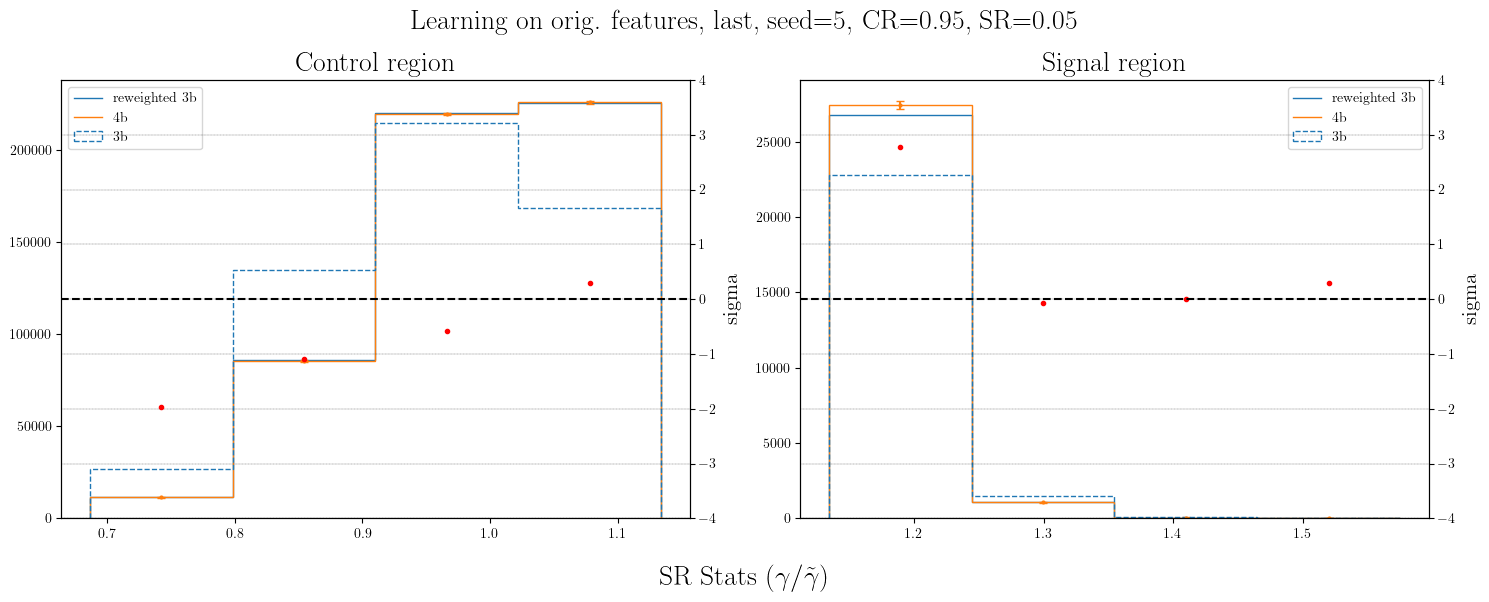

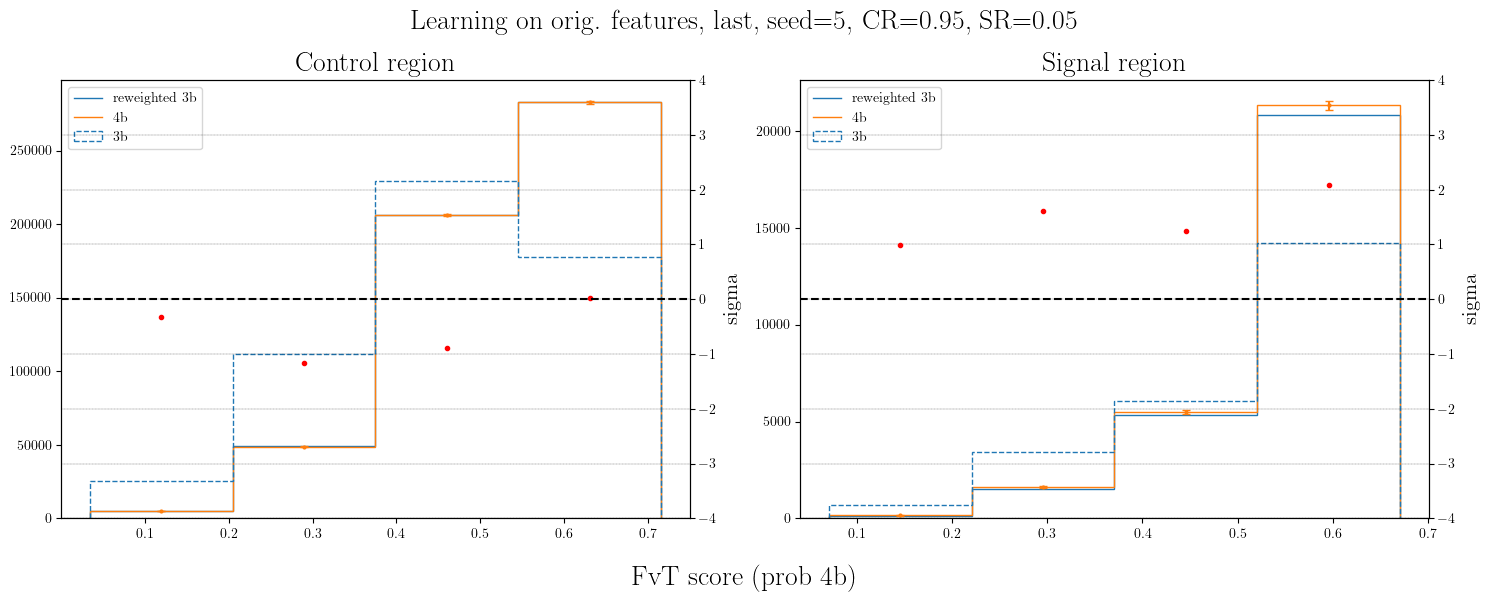

 60%|██████    | 6/10 [02:40<01:46, 26.75s/it]

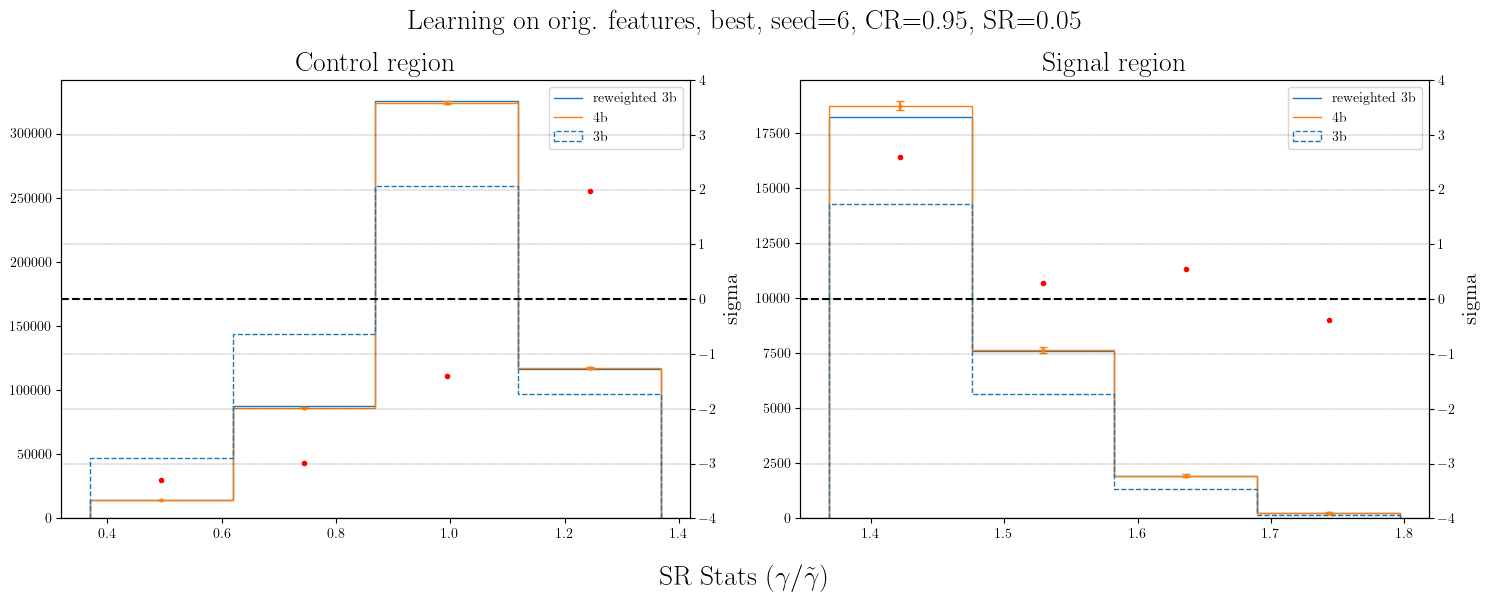

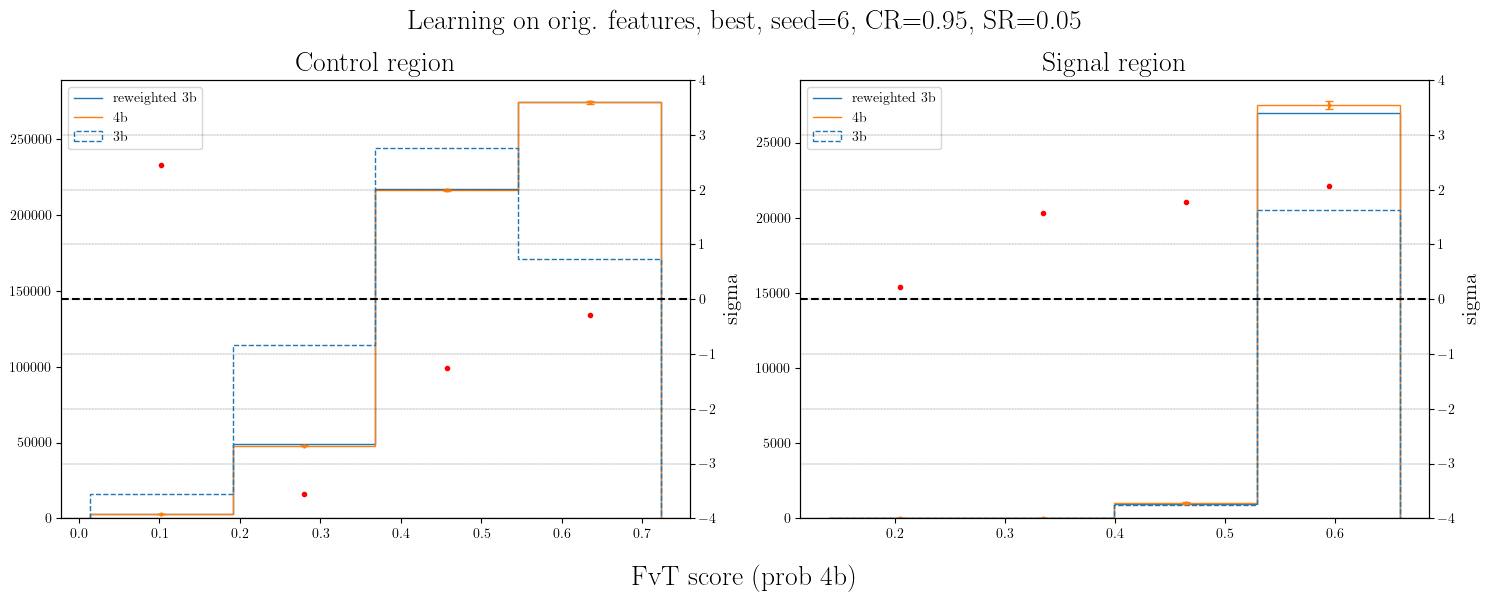

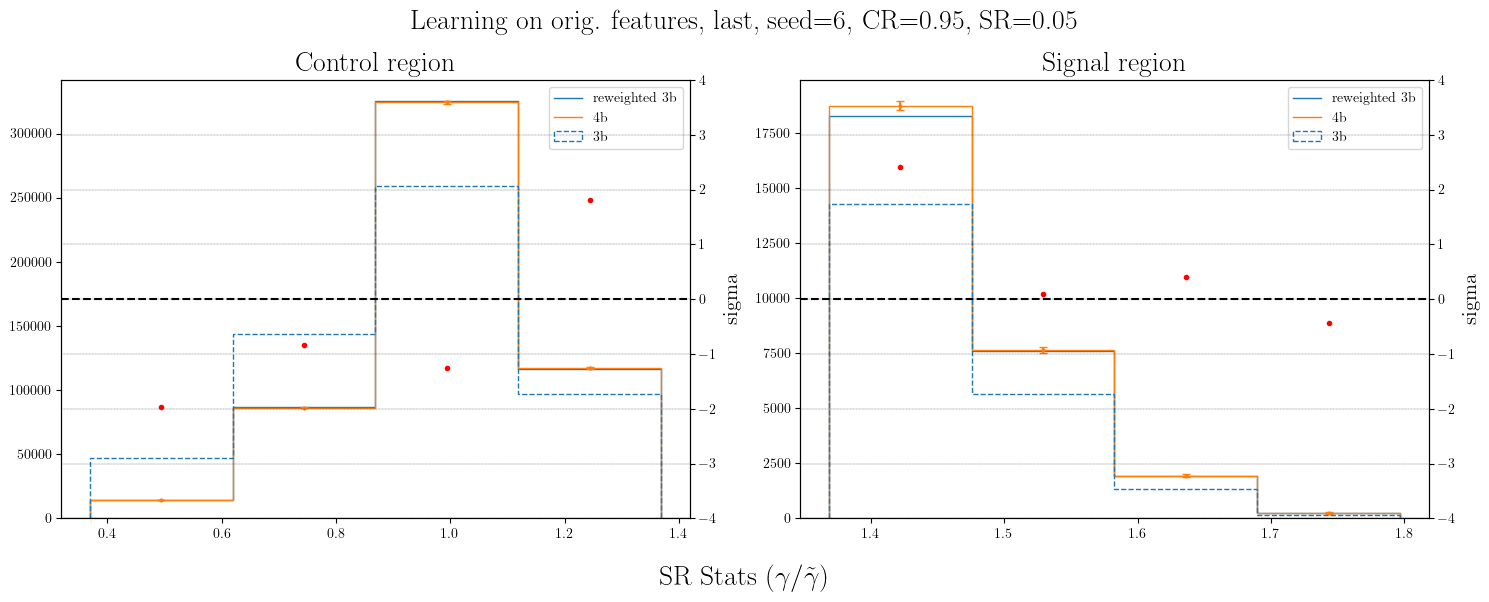

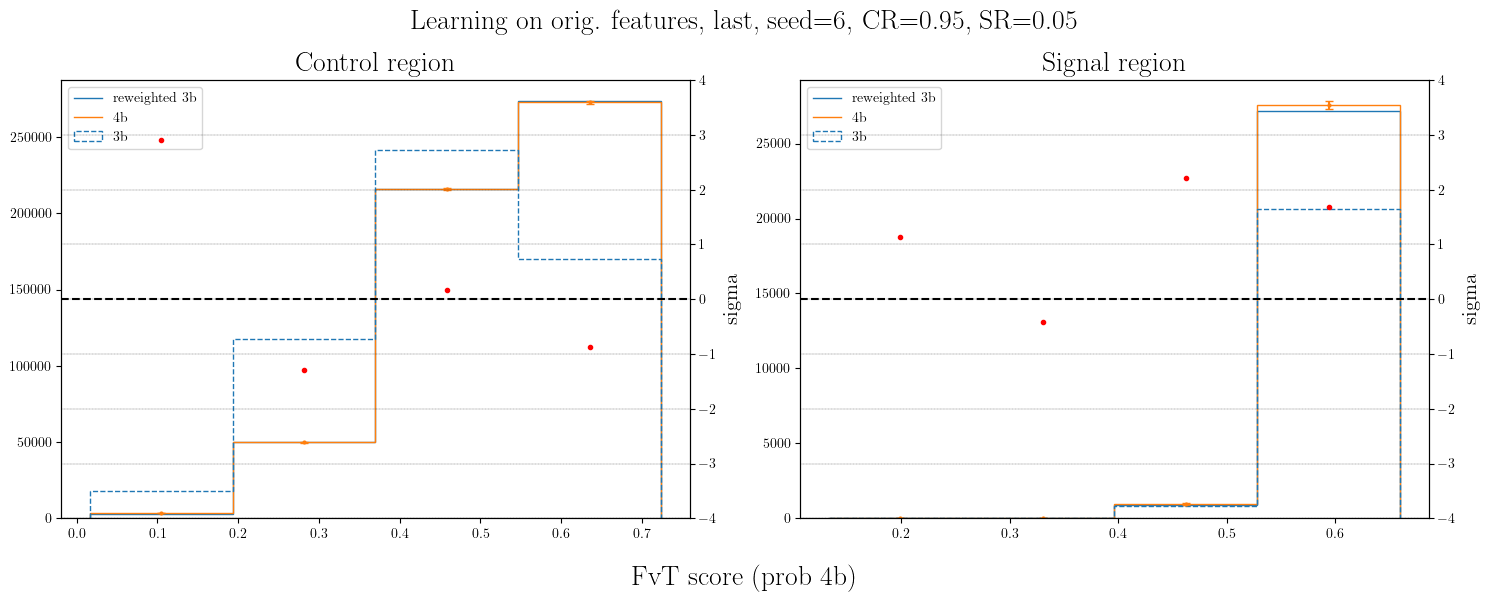

 70%|███████   | 7/10 [03:07<01:20, 26.79s/it]

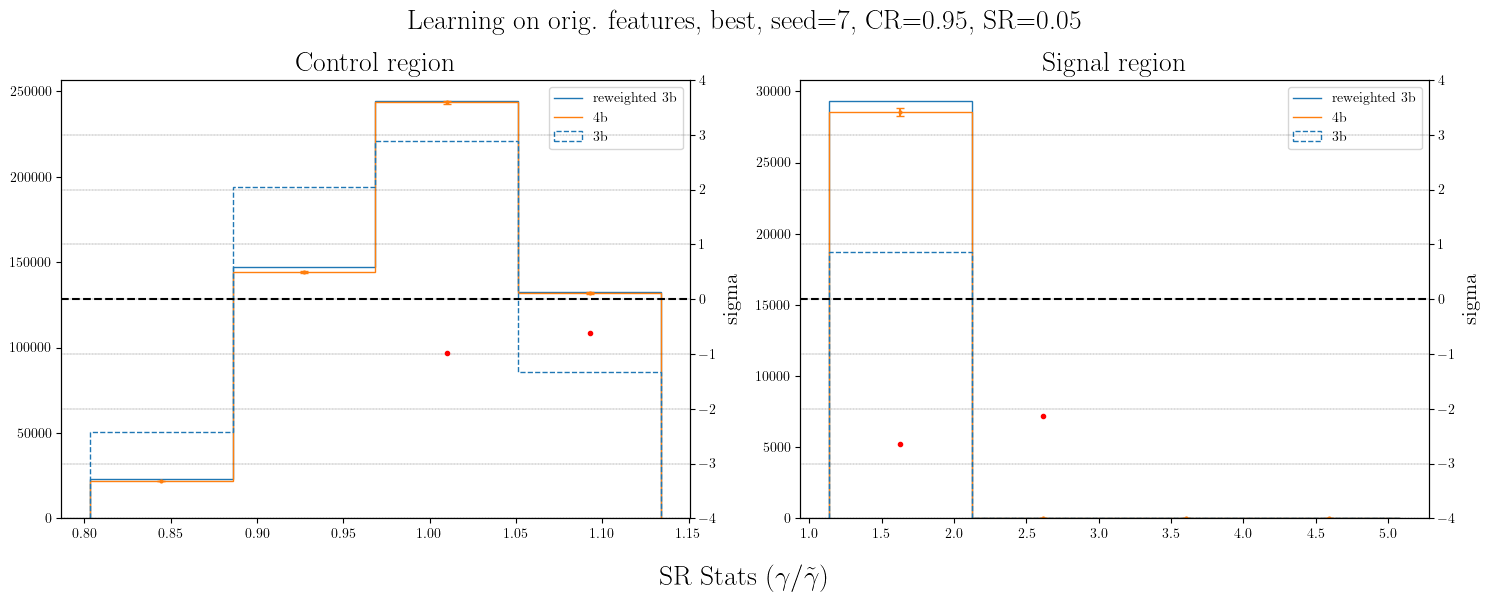

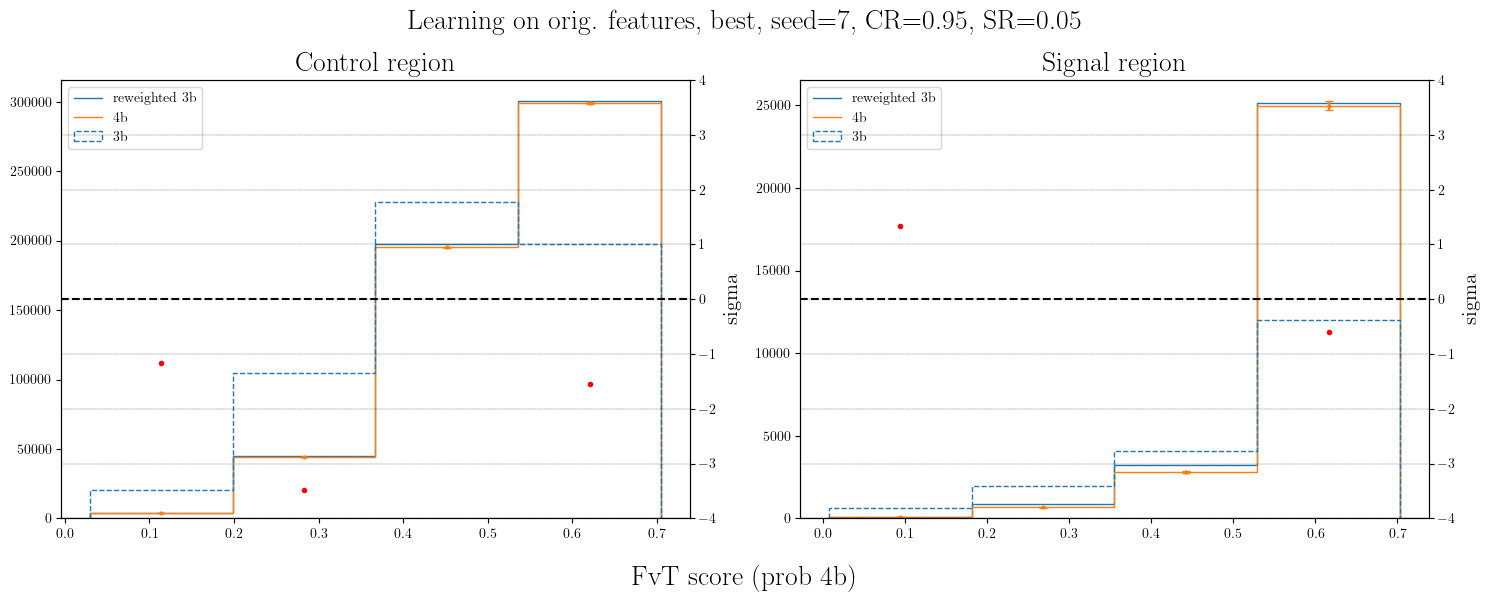

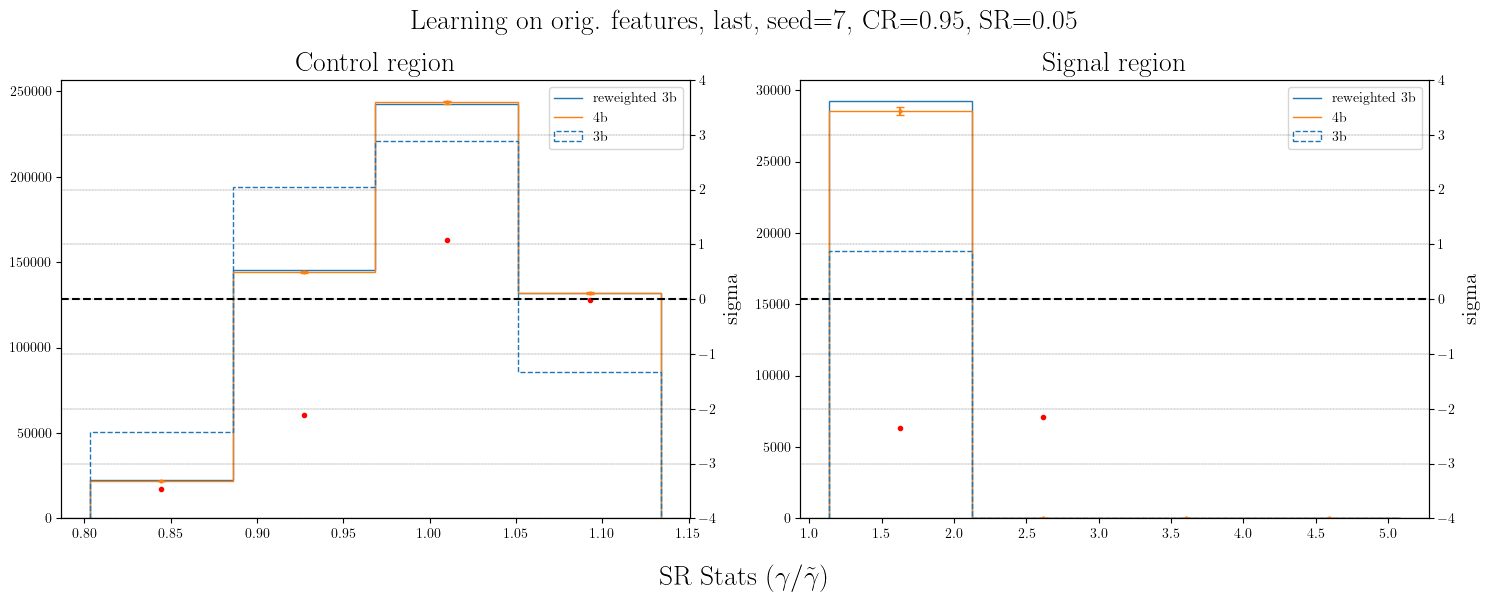

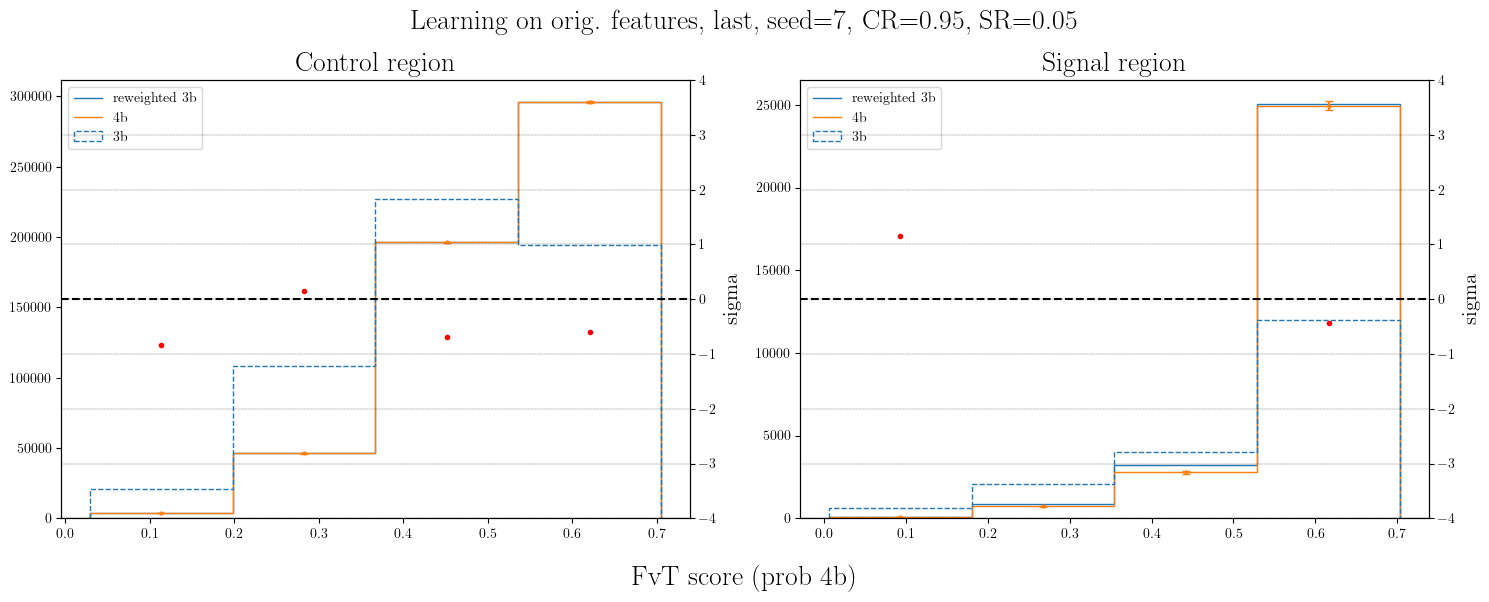

 80%|████████  | 8/10 [03:34<00:53, 26.82s/it]

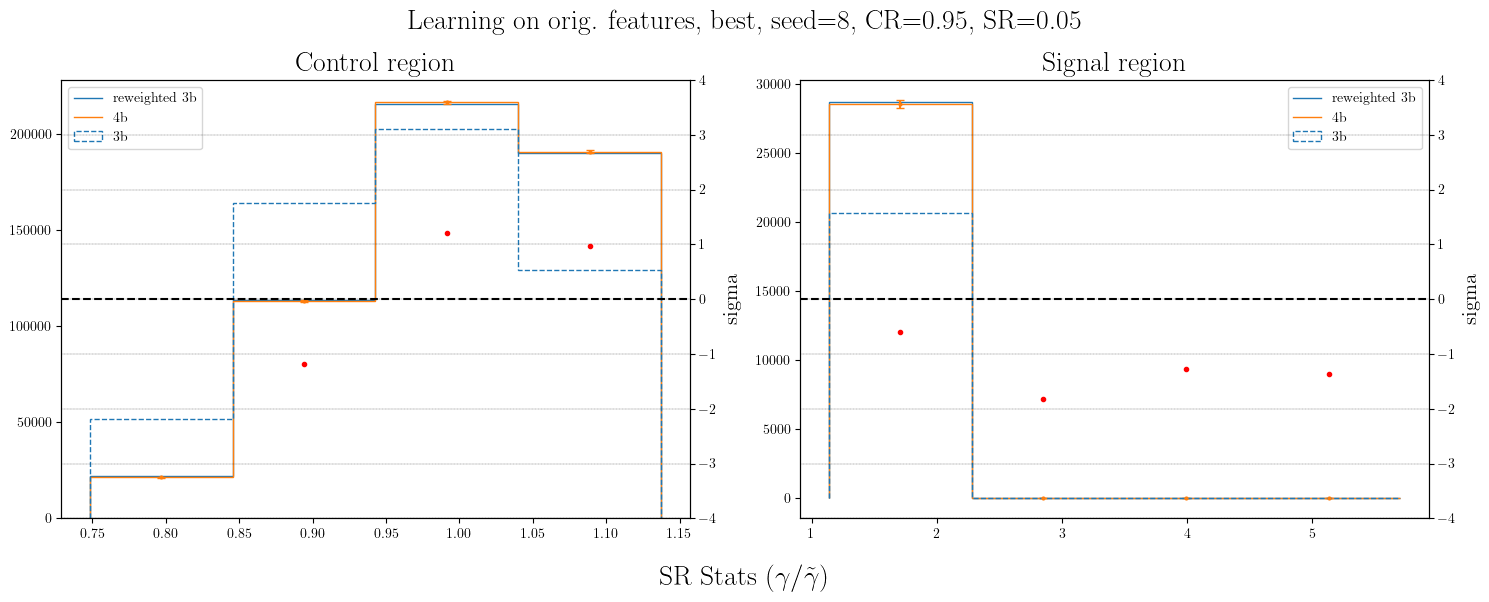

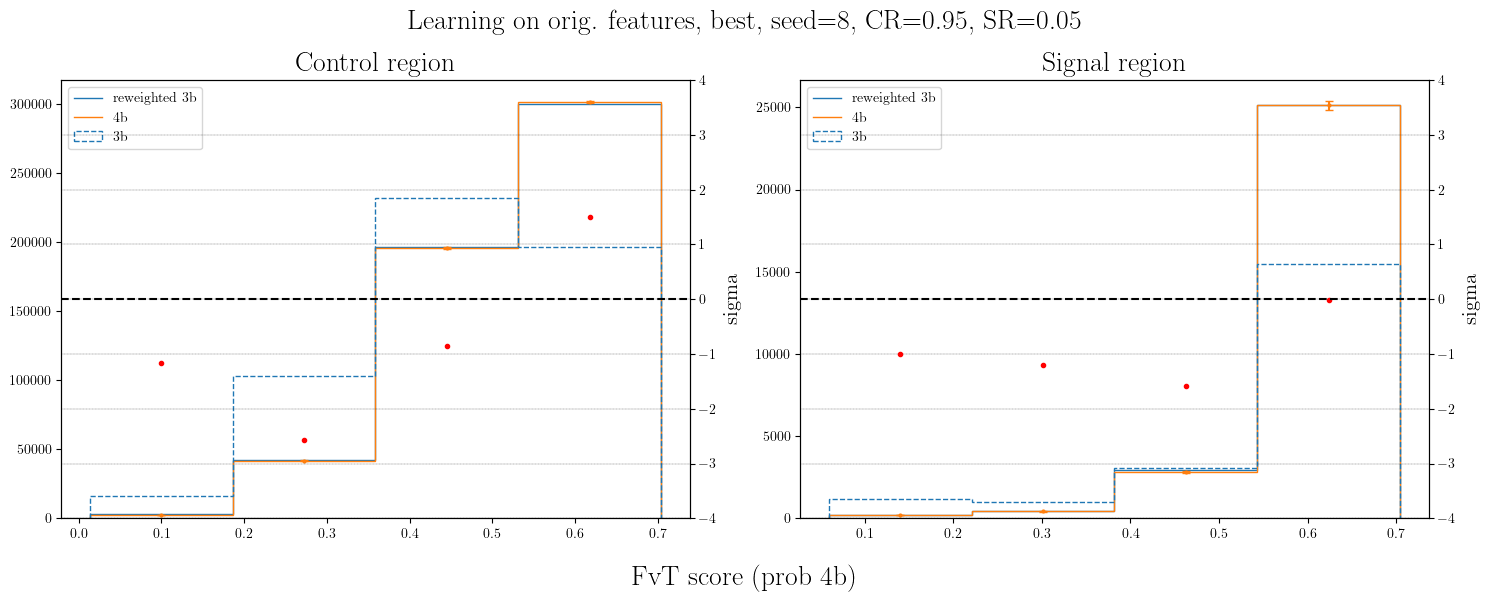

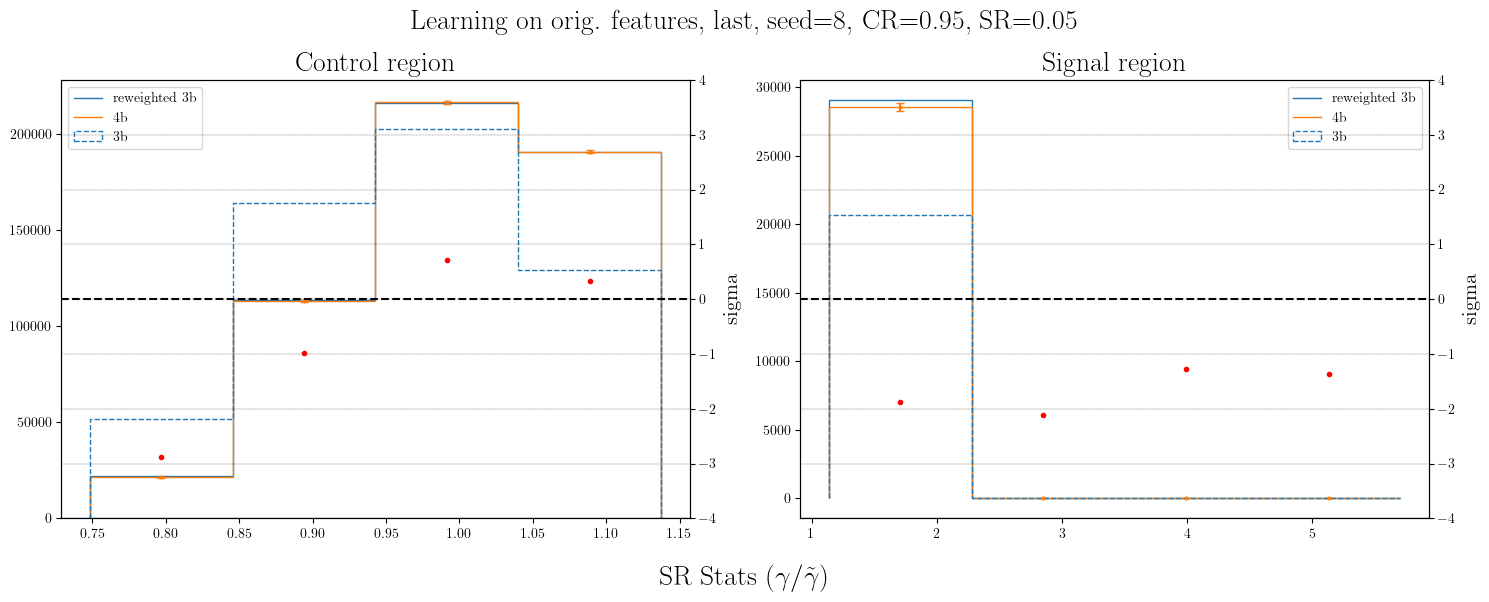

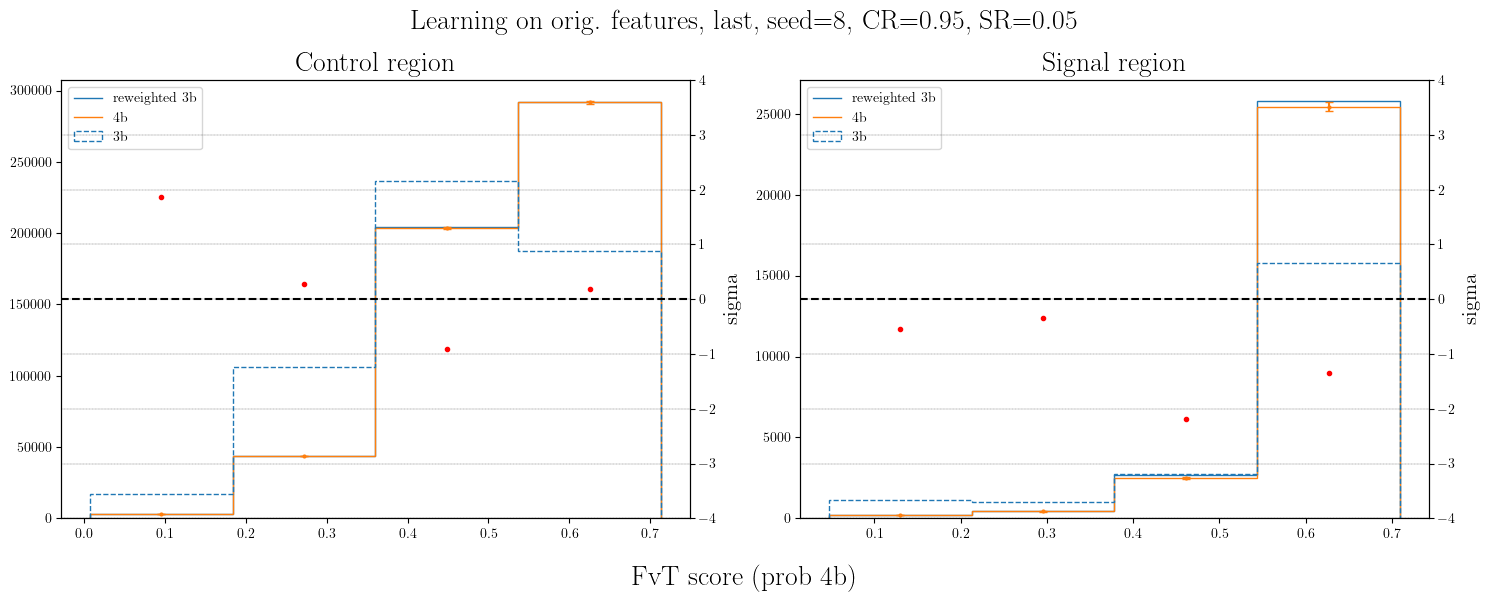

 90%|█████████ | 9/10 [04:01<00:26, 26.86s/it]

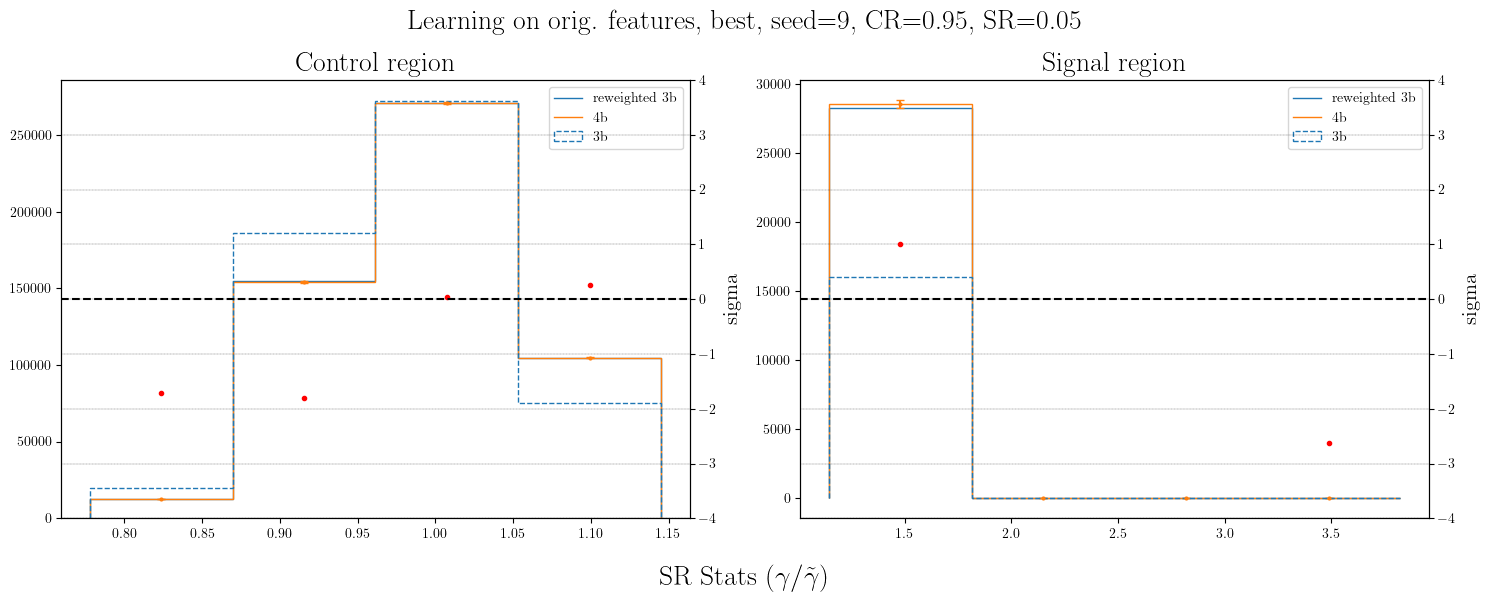

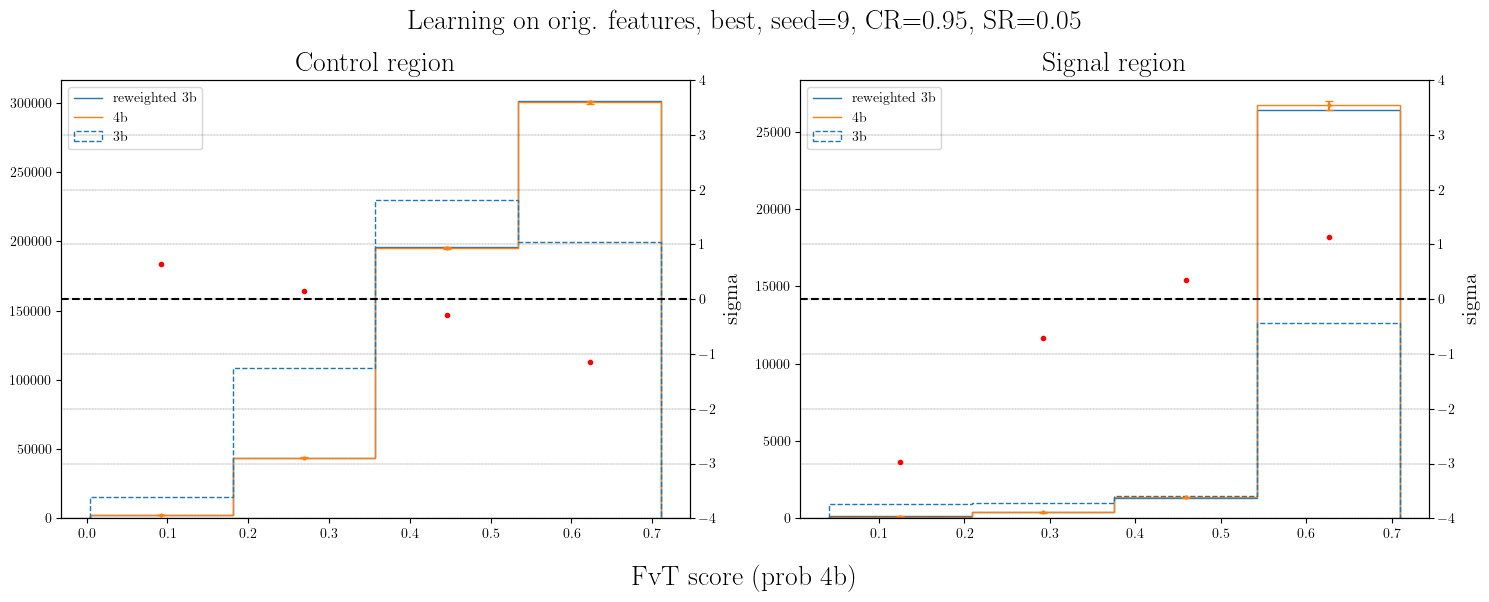

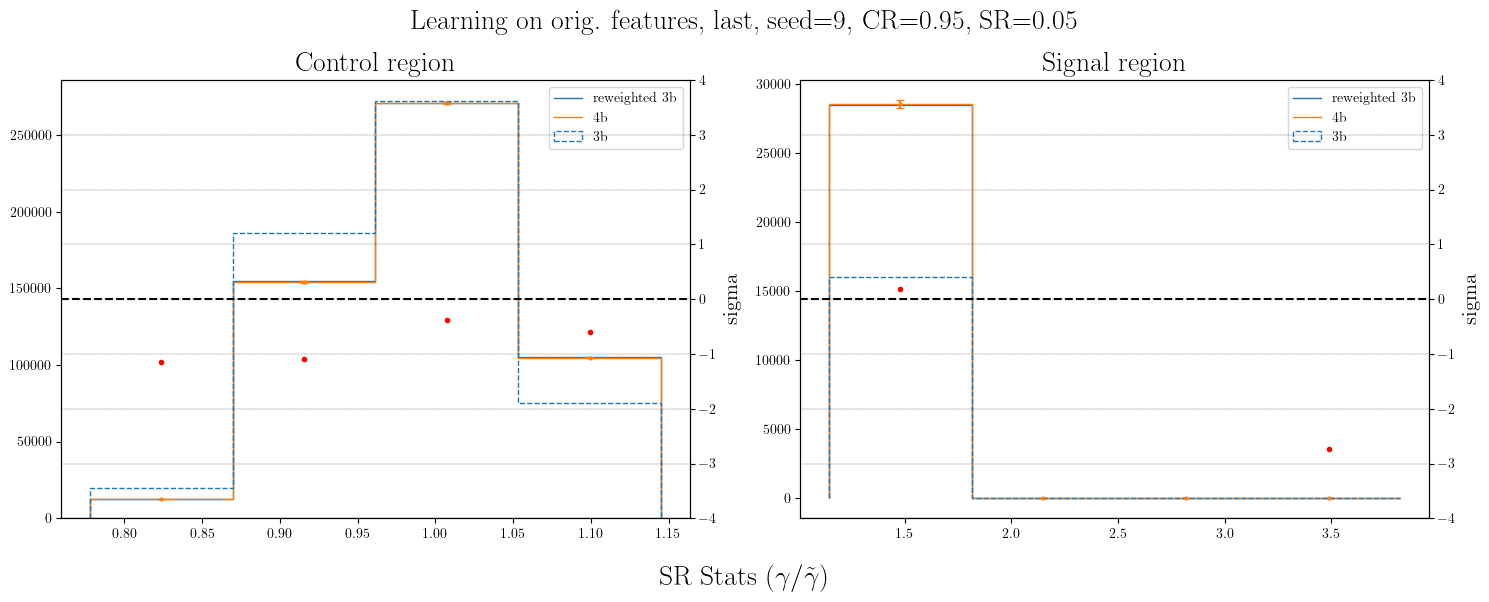

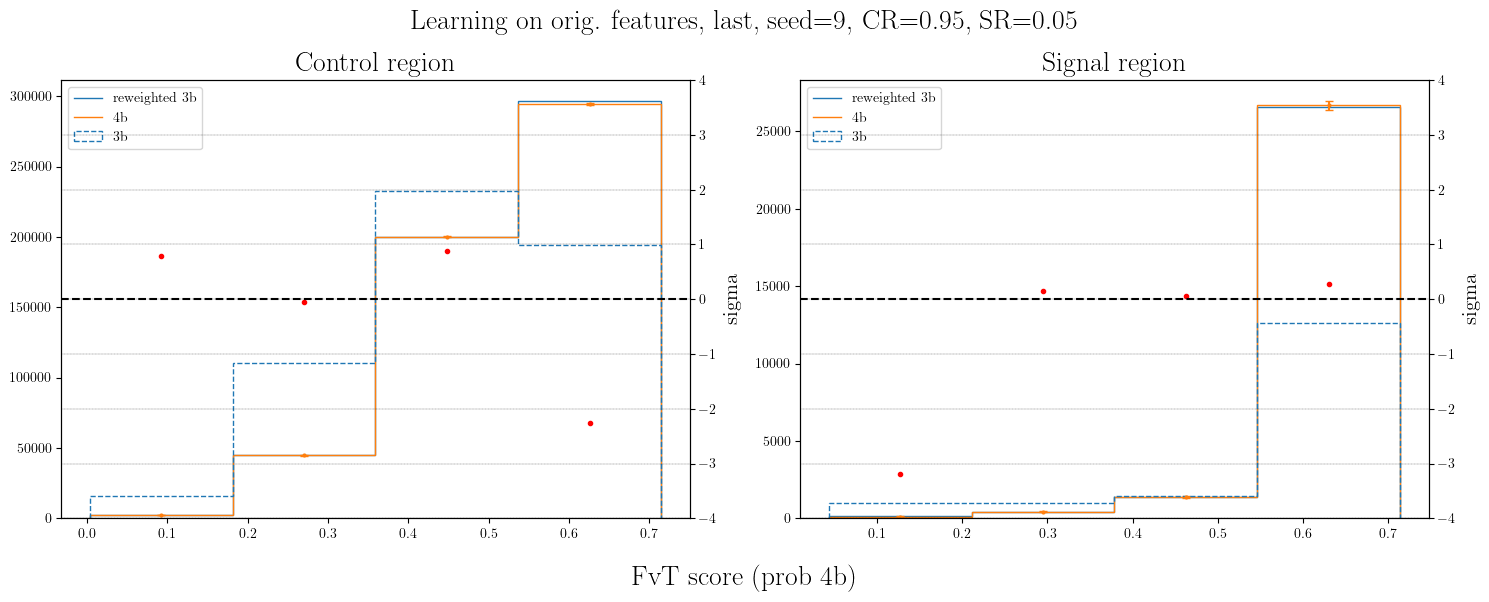

100%|██████████| 10/10 [04:29<00:00, 26.91s/it]


In [21]:
import time
import pytorch_lightning as pl
import yaml
from events_data import events_from_scdinfo
from dataset import MotherSamples
from training_info import TrainingInfo
from attention_classifier import AttentionClassifier
from plots import plot_sr_stats
import tqdm
from torch.utils.data import TensorDataset

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "smeared_fvt_training"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
seeds = np.arange(10)
signal_ratio = 0.0

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "dataset": lambda x: all([x["seed"] in seeds, 
                            x["n_3b"] == n_3b, 
                            x["signal_ratio"] == signal_ratio]),
    "model": "AttentionClassifier"
}
hashes = TrainingInfo.find(hparam_filter)

SRCR_hparams = {
    "4b_in_SR": 0.05,
    "4b_in_CR": 0.95
}
nbins = 5
cal_bins = np.linspace(0, 1, nbins)
quantiles = np.linspace(0, 1, nbins)

for tinfo_hash in tqdm.tqdm(hashes):
    smeared_tinfo = TrainingInfo.load(tinfo_hash)
    seed = smeared_tinfo.hparams["dataset"]["seed"]
    smeared_fvt = smeared_tinfo.load_trained_model("best")
    smeared_fvt.eval()
    smeared_fvt.to(device)
    
    base_tinfo = TrainingInfo.load(smeared_tinfo.hparams["encoder_hash"])
    loaded = torch.load(f"./data/checkpoints/{base_tinfo.hash}_best.ckpt")
    base_fvt = base_tinfo.load_trained_model("best")
    base_fvt.eval()
    base_fvt.to(device)
    
    msamples = MotherSamples.load(smeared_tinfo.ms_hash)
    tst_scdinfo = msamples.scdinfo[~smeared_tinfo.ms_idx]
    events_tst = events_from_scdinfo(tst_scdinfo, features, signal_filename)
    # Should not be shuffled
    
    probs_4b_base = base_fvt.predict(events_tst.X_torch)[:, 1].detach().cpu().numpy()
    q_repr_tst = base_fvt.representations(events_tst.X_torch)[0]
    probs_4b_smeared = smeared_fvt.predict(q_repr_tst)[:, 1].detach().cpu().numpy()
    gamma_base = probs_4b_base / (1 - probs_4b_base)
    gamma_smeared = probs_4b_smeared / (1 - probs_4b_smeared)
    
    SR_stats = gamma_base / gamma_smeared
    
    SR_cut, CR_cut = get_SR_CR_cut(SR_stats, events_tst, SRCR_hparams)
    
    SR_idx = (SR_stats >= SR_cut)
    CR_idx = (SR_stats >= CR_cut) & (SR_stats < SR_cut)
    
    events_tst_SR = events_tst[SR_idx]
    events_tst_CR = events_tst[CR_idx]
    
    
    for mode in ["best", "last"]:
    # for mode in ["best"]:
        CR_fvt = FvTClassifier.load_from_checkpoint(f"./data/tmp/checkpoints/CR_fvt_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_signal_ratio_{signal_ratio}_{mode}.ckpt")
        CR_fvt.eval()
        CR_fvt.to(device)
        
        
            
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"Learning on orig. features, {mode}, seed={seed}, CR={SRCR_hparams['4b_in_CR']}, SR={SRCR_hparams['4b_in_SR']}")
        fig.supxlabel(fr"SR Stats ($\gamma / \tilde\gamma$)")
        ax[0].set_title(f"Control region")
        ax[1].set_title(f"Signal region")

        fvt_scores_SR = CR_fvt.predict(events_tst_SR.X_torch)[:, 1].detach().cpu().numpy()
        fvt_scores_CR = CR_fvt.predict(events_tst_CR.X_torch)[:, 1].detach().cpu().numpy()
        
        # CR_cal_bins = np.quantile(SR_stats[CR_idx], quantiles)
        # SR_cal_bins = np.quantile(SR_stats[SR_idx], quantiles)
        CR_cal_bins = np.linspace(np.min(SR_stats[CR_idx]), np.max(SR_stats[CR_idx]), nbins)
        SR_cal_bins = np.linspace(np.min(SR_stats[SR_idx]), np.max(SR_stats[SR_idx]), nbins)

        plot_rewighted_samples_by_model(events_tst_CR,
                                        x_values=SR_stats[CR_idx],
                                        fvt_scores=fvt_scores_CR,
                                        bins=CR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[0],
                                        )
        ax[0].hist(SR_stats[CR_idx][events_tst_CR.is_3b], bins=CR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_CR.weights[events_tst_CR.is_3b])
        ax[0].legend()

        plot_rewighted_samples_by_model(events_tst_SR,
                                        x_values=SR_stats[SR_idx],
                                        fvt_scores=fvt_scores_SR,
                                        bins=SR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[1],
                                        )
        ax[1].hist(SR_stats[SR_idx][events_tst_SR.is_3b], bins=SR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_SR.weights[events_tst_SR.is_3b])
        ax[1].legend()

        plt.tight_layout()
        # plt.savefig(f"./data/plots/Learning on orig. features, {mode}_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_SR_stats.pdf", dpi=300)
        plt.show()
        plt.close("all")
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"Learning on orig. features, {mode}, seed={seed}, CR={SRCR_hparams['4b_in_CR']}, SR={SRCR_hparams['4b_in_SR']}")
        fig.supxlabel(fr"FvT score (prob 4b)")
        ax[0].set_title(f"Control region")
        ax[1].set_title(f"Signal region")
        
        CR_cal_bins = np.linspace(np.min(fvt_scores_CR), np.max(fvt_scores_CR), nbins)
        SR_cal_bins = np.linspace(np.min(fvt_scores_SR), np.max(fvt_scores_SR), nbins)

        plot_rewighted_samples_by_model(events_tst_CR,
                                        x_values=fvt_scores_CR,
                                        fvt_scores=fvt_scores_CR,
                                        bins=CR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[0],
                                        )
        ax[0].hist(fvt_scores_CR[events_tst_CR.is_3b], bins=CR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_CR.weights[events_tst_CR.is_3b])
        ax[0].legend()

        plot_rewighted_samples_by_model(events_tst_SR,
                                        x_values=fvt_scores_SR,
                                        fvt_scores=fvt_scores_SR,
                                        bins=SR_cal_bins, figsize=(10, 5), ratio_4b=ratio_4b, ax=ax[1],
                                        )
        ax[1].hist(fvt_scores_SR[events_tst_SR.is_3b], bins=SR_cal_bins, label="3b", histtype="step", linestyle="--", 
                weights=events_tst_SR.weights[events_tst_SR.is_3b])
        ax[1].legend()

        plt.tight_layout()
        # plt.savefig(f"./data/plots/Learning on orig. features, {mode}_seed_{seed}_CR_{SRCR_hparams['4b_in_CR']}_SR_{SRCR_hparams['4b_in_SR']}_FvT_score.pdf", dpi=300)
        plt.show()
        plt.close("all")